# `Process Data`

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import transit
import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import astropy

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema, medfilt
from random import uniform, randrange

import kplr
from kplr.ld import get_quad_coeffs

import time
from collections import Counter, defaultdict, OrderedDict

import glob, os
import itertools

In [2]:
rcParams['figure.figsize'] = 16, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [3]:
pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}'
        r'\usepackage{amsmath}' #for \text command
    ]
}

rcParams.update(pgf_with_latex)

# Introduction

## Load the data

In [4]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [5]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

Check files:
*Lengths don't match: 55 984
	Some systems have both sc and lc data! Remove duplicates.
*Lengths match: 55 55
	Duplicates have been removed.
 A total of 55 systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet


(55, 141)

## Define the Systems

In [6]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_solarRad, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans,dt_trans,
                res_transfit, P_distribution, MCMC_transits):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_solarRad = rp*0.009168 # in solar radii
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        self.res_transfit = np.empty(0)
        self.P_distribution = np.empty(0)
        self.MCMC_transits = np.empty(0)

## Characterize the Systems

Some initialization functions: `quadraticLD`calculates the quadratic LD coefficients of a star based on the model from Claret & Bloemen (2011). As for `fetchLC`, it simply loads the systems' light curves.

In [7]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

Create the planet+star system. In this research, we will only evaluate systems with only 1 planet. 

In [8]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.sqrt(rp_errPos**2+rp_errNeg**2)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, None, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Global Parameters

MCMC Global Initialization Parameters

In [12]:
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
G = 6.6730e-11
steps, nwalkers, burnin_global = 6000, 100, 2000
steps_rho, nwalkers_rho = 2000, 100
snr_limit = 3

In [13]:
poly_order = 3
amplify = 2
print("Amplification of transit duration by:", amplify)

Amplification of transit duration by: 2


In [14]:
period_guess = 100 #randrange(14,500) #uniform(13.5, 500) print("Period guess [d]:", period_guess)

In [15]:
id_mcmc = ["Depth:", "Impact parameter (b):", "sigma:", "Stellar Mass (Ms, [Solar mass]):",
           "Stellar Radius (Rs, [Solar Radii]):", "Out-of-transit flux (f0):", "Orbital Period (P, [days]):", 
           "Time of transit (tc, [days]):", "Planetary Radius (Rp, [Rearth]):", "Rs_a:"]

header_mcmc = "This file shows the 50% percentile and the +- 1 sigma error interval of the parameters.\n"

header_rs = "This file shows the 50% percentile for the Stellar Radius (in solar radii), \
its +- 1 sigma error interval, and the MCMC acceptance fraction (in %). Note that these results \
are for the star's *observed* transits with a minimum SNR of {0:d}. \n".format(snr_limit)

# Transit Detection

In [16]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [17]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.', ms = 2)     
        plt.title('Folded LC for KID'+str(star.kepid))
        plt.xlabel('Time from midtransit [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title('KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                plt.figure(figsize=(15,6))
                plt.title('Transit '+str(i+1))
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.', ms = 2)     
                plt.xlabel('Time from midtransit [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.2)
                plt.close()

In [18]:
def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
    star.trans_id = flag_transit #The counter starts at 0 (in other words, trans_id == 0 is already the first transit)
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [19]:
def oot_fit(star, poly):
    transit_range = star.duration/2     
    
    if star.kepid == 8156120:
        poly = 5
    
    if star.kepid == 5812701:
        poly = 7
        
    if star.kepid == 12365184:
        transit_range += 0.08
    
    for i in range(len(star.transit_times)):
        dt = star.ttrans[star.trans_id == i] - star.transit_times[i]
        y = star.ftrans[star.trans_id==i]
        yerr = star.ftrans_err[star.trans_id==i]
        
        outside_trans = np.abs(dt) >= transit_range
        inside_trans = np.abs(dt) < transit_range
        num_oot_points = len(dt[outside_trans])
        
        if  (num_oot_points!= 0):
            coeffs = np.polyfit(dt[outside_trans], y[outside_trans], poly)
            baseline_fitted = np.polyval(coeffs, dt)
            
            newY = y/baseline_fitted
            newYerr = yerr/baseline_fitted 
                    
            fig = plt.figure()
            plt.plot(dt, y, 'mo', label = 'lc')
            plt.plot(dt[outside_trans], y[outside_trans], '.', label ='oot')
            plt.plot(dt, baseline_fitted, '.', label ='baseline')
            plt.plot(dt, newY, 'y-', label ='y/baseline')
            plt.legend()
            filepath_oot = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/oot_fit/'
            store_oot = "oot"+str(star.kepid)+"_trans"+str(i+1)+"_poly"+str(poly)+".png"
            fig.savefig(filepath_oot+store_oot)
            #plt.show(block=False)    
            #time.sleep(0.1)
            plt.close(fig)
            
            star.ftrans[star.trans_id==i] = newY
            star.ftrans_err[star.trans_id==i] = newYerr

In [20]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

In [21]:
def export_folded_lc(system):
    lc = pd.DataFrame(OrderedDict({'Time': system.time_BKJD, 'Flux': system.flux, 'Flux_Err': system.flux_err}))
     
    np.savetxt("/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/folded_LC/"+str(system.kepid)+".txt", 
               lc.values, fmt='%f', delimiter="\t") 

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [22]:
stars_wo_transits = []

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************\n")
    target.transit_times = find_transits(target)    
    get_data_in_transit(target, amplify)

    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)

    target.ind_missed_transits = find_missed_transits(target) # On notation: Imagine target.ind_missed_transits = [18]. This means 
                                                              # that the transit with flag_id = 18 hasn't been observed (and not the transit 
                                                              # with flag_id = 17)
    oot_fit(target, poly_order)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)

    if len(observed_transits!=0): show_folded_lightcurve(target, False)

    export_folded_lc(target)

    print("Transit duration: {0:0.5} [d]".format(target.duration))
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)


******************************** KID11133306 ********************************

Transit duration: 0.19219 [d]
Period: 41.74598855 [d]
Estimated transits at (26): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1295.7948533  1337.54084185
 1379.2868304  1421.03281895 1462.7788075  1504.52479605 1546.2707846
 1588.01677315]
Observed transits at (25): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1337.54084185 1379.2868304
 1421.03281895 1462.7788075  1504.52479605 1546.2707846  1588.01677315]
Index of missed transits: [18]

******************************** KID3733628 **************

Transit duration: 0.20198 [d]
Period: 29.90721859 [d]
Estimated transits at (1): [773.4377418]
Observed transits at (1): [773.4377418]
Index of missed transits: []

******************************** KID11027624 ********************************

Transit duration: 1.0045 [d]
Period: 394.6249514 [d]
Estimated transits at (0): []
Observed transits at (0): []
Index of missed transits: []

******************************** KID5009743 ********************************

Transit duration: 0.2377 [d]
Period: 41.6980186 [d]
Estimated transits at (1): [878.4417962]
Observed transits at (1): [878.4417962]
Index of missed transits: []

******************************** KID2853093 ********************************

Transit duration: 0.15306 [d]
Period: 161.5278347 [d]
Estimated transits at (1): [1005.6405435]
Observed transits at (1): [1005.6405435]
Index of missed transits: []

******************************** KID6442377 ********************************

Transit duration: 0.27813 [d]
Period: 30.22910274 

Transit duration: 0.21007 [d]
Period: 38.47876629 [d]
Estimated transits at (27): [ 267.28911087  305.76787716  344.24664345  382.72540974  421.20417603
  459.68294232  498.16170861  536.6404749   575.11924119  613.59800748
  652.07677377  690.55554006  729.03430635  767.51307264  805.99183893
  844.47060522  882.94937151  921.4281378   959.90690409  998.38567038
 1036.86443667 1075.34320296 1113.82196925 1152.30073554 1190.77950183
 1229.25826812 1267.73703441]
Observed transits at (11): [ 267.28911087  305.76787716  344.24664345  382.72540974  421.20417603
  536.6404749   575.11924119  613.59800748 1190.77950183 1229.25826812
 1267.73703441]
Index of missed transits: [23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 6, 5]

******************************** KID3835670 ********************************

Transit duration: 0.32351 [d]
Period: 14.55730897 [d]
Estimated transits at (38): [261.55348376 276.11079273 290.6681017  305.22541067 319.78271964
 334.34002861 348.89733758 363.4

In [21]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))
print(stars_wo_transits)

There are 4 stars without transits. These targets won't be studied
[11027624, 11622600, 7761545, 10795103]


In [ ]:
print(steps)
print(steps_rho)

# Fit of the Stellar Density

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [27]:
def lnprior_rho(theta, maxb):
    pdepth, pb, sigma, pradius, f0, ptc, sumLD = theta 
    if ((0.3 < sumLD < 1.0) and (0 <= pb < maxb) and (0 <= sigma)\
         and (pradius > 0) and (pdepth > 0) and (ptc**2<0.01)):
        return 0.0
    return -np.inf  

def lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc,  mass, masserr, tKep, maxb, P, diffLD = allfixed
    pdepth, pb, sigma, pradius, f0, ptc, sumLD = theta 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
 
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=P, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))
    return chi2
                 
def lnprob_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, tKep, maxb, P, diffLD = allfixed
    lp_rho = lnprior_rho(theta, maxb)
    if not np.isfinite(lp_rho):
        return -np.inf
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)

## MCMC

In [28]:
def fit_rho(star, t, f, ferr, num_trans, showLC, showMCMC):
    
    max_b = 1+star.rp_solarRad/star.rs
    print("\nMax b (rp in Solar Radius):", max_b)
    
    allfixed_rho = np.array([star.eccen, star.smass, 0.0, tKep, max_b, star.P, star.diffld])
    first_guess =  np.array([star.depth/1.2, star.b, 0.0, star.rs, 1.0, 0.0, (star.u1+star.u2)])
    
    nll_rho = lambda *args: -lnprob_rho(*args)
       
    result = op.minimize(nll_rho, first_guess, args=(t, f, ferr, allfixed_rho), 
                       options={'maxiter':1e5,'disp': True},
                       method='Nelder-Mead') 
    
    depth_ml, b_ml, sigma_ml, radius_ml, f0_ml, tc_ml, sumLD_ml = result["x"]
    
    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml - u1_ml

    
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=u1_ml, mu2= u2_ml, 
                                       mass=star.smass, radius=radius_ml))
    
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml, period = star.P, t0 = tc_ml, b = np.abs(b_ml), e = star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=5)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,7))
        plt.title(str(star.kepid)+'. Stellar Density Fit for Transit '+str(num_trans+1), fontsize = 15)
        plt.plot(t, f, '.')
        plt.plot(t_fit, f_fit, color='r', lw = 3)
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
       
    ndim_rho = len(result["x"])
    
    p0 = [result["x"]*(1+1e-8*np.random.randn(ndim_rho)) for i in range(nwalkers_rho)]
    sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho, args=(t, f, ferr, allfixed_rho))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 200, progress = True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps_rho, rstate0 = state, progress=True);
    samples = sampler.chain[:, 250:, :].reshape((-1, ndim_rho)) #burnin currently set to 10%
    
    samples[:, 2] = np.exp(samples[:, 2])
    
    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, \
    rs_mcmc, f0_mcmc, tc_mcmc, sumLD_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    # Readjust LD coefficients. 
    u1_mcmc = 0.5*(sumLD_mcmc[0] + star.diffld)
    u2_mcmc = sumLD_mcmc[0] - u1_mcmc

    if showMCMC == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tREPORTED = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0], rs_mcmc[1],rs_mcmc[2]))
        print("\nSum LD Coefficients:\n\tREPORTED = {:0.3f}".format(star.u1+star.u2))
        print("\tu1 MCMC Fit  = {0:0.3f}".format(u1_mcmc))
        print("\tu2 MCMC Fit  = {0:0.3f}".format(u2_mcmc))
        
    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=u1_mcmc, mu2=u2_mcmc, mass=star.smass, radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=star.P, t0=tc_mcmc[0], 
                        b=np.abs(b_mcmc[0]), e = star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.')
    plt.plot(t_fit, f_fit, 'r', lw = 3)
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)])
    
    filepath_rho = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    store_lcfit = "fit"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(filepath_rho+store_lcfit)
    plt.close(fig_lc)
        
    true_params = [star.depth, star.b, None, star.rs, 1.0, 0.0, (star.u1+star.u2)]
    res_labels = [r'Depth', r'$b$', r'$\sigma$', r'$R_{s} [R_{\odot}]$', r'$f_{0}$', r'$t_{c}$', r'$u_{1}+u_{2}$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles = [0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args = {"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints = True) 
        
    plt.suptitle("KID"+str(star.kepid)+". Corner Plot for Transit "+str(num_trans+1), fontsize = 20)
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(filepath_rho+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: s a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(af_percentage))
    
    #Steps plot
    fig_steps, axes = plt.subplots(ndim_rho, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); 
    axes[0].axhline(true_params[0], color='red')
    
    axes[1].plot(sampler.chain[:, :, 1].T, ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); 
    axes[1].axhline(true_params[1], color='red')
    
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$R_{s} [R_{\odot}]$'); 
    axes[3].axhline(true_params[3], color='red')
    
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$f_{0}$'); 
    axes[4].axhline(true_params[4], color='red')
    
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted',color="xkcd:sky blue")
    axes[5].set_ylabel(r"$t_{c}$"); 
    axes[5].axhline(true_params[5], color='red')
    
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel(r"$u_{1}+u_{2}$"); 
    axes[6].axhline(true_params[6], color='red')
    axes[6].set_xlabel("Step number")
    
    fig_steps.tight_layout(h_pad=0.0)
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_steps.savefig(filepath_rho+store_steps)
    plt.close(fig_steps)
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, rs_mcmc, f0_mcmc, tc_mcmc, sumLD_mcmc]
    rs_results = np.array([rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]])
    
    return radius_ml, rs_results, af_percentage

Store the KID of stars with missing or bad (SNR < 3) transits 

In [29]:
no_transits = set(stars_wo_transits)
ugly_stars = defaultdict(list)

for i in range(len(stars_wo_transits)):
    idx_target = stars_wo_transits[i]
    ugly_stars[idx_target] = []
    
print(ugly_stars)

defaultdict(<class 'list'>, {11027624: [], 11622600: [], 7761545: [], 10795103: []})


## Fit individual Transits

Fit the stellar radius to obtain a better estimate of the stellar density

In [30]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")

    plt.close("all")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)

    rs_trans_fit = []
    rs_trans_afrac = []

    for i in range(len(target.transit_times)): 
        if i in missed_trans:
            ugly_stars[key].append(i)
        else: 
            print("\n\t*TRANSIT "+str(i+1))
            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]

            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)

            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
    
            snr = d/error_trans_oot

            print("\t\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\t\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))

            if snr < snr_limit or np.isnan(snr): 
                ugly_stars[key].append(i)
            else:
                rsFit, rsMCMC, rs_afraction = fit_rho(target, dt_i,  f_trans_i, 0.1*error_trans_oot, i, False, False)
                
                print("\tStellar Radius [Rsun]:\tMCMC = {0:0.5f}.\t1st Fit = {1:0.5f}.\tKepler = {2:0.5f}".format(rsMCMC[0], rsFit, target.rs))
                print("\tError Stellar Radius [Rsun]:\tMCMC (up) = {0:0.5f}, (down) = {1:0.5f}.\tOld = {2:0.5f}".format(rsMCMC[1], rsMCMC[2],  target.rs_err))

                rs_trans_fit.append(rsMCMC)
                rs_trans_afrac.append(rs_afraction)
    
    if len(rs_trans_fit) != 0:
        locs_rsNew = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
        fname_rsNew = str(target.kepid)+"_st"+str(steps_rho)+"_RsMCMC.txt"
        np.savetxt(locs_rsNew+fname_rsNew, np.column_stack((rs_trans_fit, rs_trans_afrac)), 
                               fmt = "%0.3f", header = header_rs)


******************************** KID11133306 ********************************

	*TRANSIT 1
		Signal = 0.00038. Noise (rms) = 0.00030. SNR = 1.27823
		Out-of-transit error of the transit LC = 0.00030

	*TRANSIT 2
		Signal = 0.00039. Noise (rms) = 0.00029. SNR = 1.34154
		Out-of-transit error of the transit LC = 0.00029

	*TRANSIT 3
		Signal = 0.00036. Noise (rms) = 0.00028. SNR = 1.25945
		Out-of-transit error of the transit LC = 0.00028

	*TRANSIT 4
		Signal = 0.00034. Noise (rms) = 0.00028. SNR = 1.21716
		Out-of-transit error of the transit LC = 0.00028

	*TRANSIT 5
		Signal = 0.00024. Noise (rms) = 0.00028. SNR = 0.85699
		Out-of-transit error of the transit LC = 0.00028

	*TRANSIT 6
		Signal = 0.00032. Noise (rms) = 0.00029. SNR = 1.10424
		Out-of-transit error of the transit LC = 0.00029

	*TRANSIT 7
		Signal = 0.00036. Noise (rms) = 0.00028. SNR = 1.26480
		Out-of-transit error of the transit LC = 0.00028

	*TRANSIT 8
		Signal = 0.00038. Noise (rms) = 0.00029. SNR = 1.28654
		Ou

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7292.650855
         Iterations: 653
         Function evaluations: 1006


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:25,  9.72it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:05<00:00, 10.80it/s]


Mean acceptance fraction: 0.29046500000000003
Acceptance fraction: 29.05 %
	Stellar Radius [Rsun]:	MCMC = 0.95925.	1st Fit = 0.96235.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.20837, (down) = 0.13426.	Old = 0.04965

	*TRANSIT 2
		Signal = 0.00054. Noise (rms) = 0.00017. SNR = 3.21174
		Out-of-transit error of the transit LC = 0.00017

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7639.171224
         Iterations: 711
         Function evaluations: 1086
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:19<00:00, 10.01it/s]


Mean acceptance fraction: 0.32740499999999995
Acceptance fraction: 32.74 %
	Stellar Radius [Rsun]:	MCMC = 1.47406.	1st Fit = 1.33029.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.22435, (down) = 0.27219.	Old = 0.04965

	*TRANSIT 9
		Signal = 0.00048. Noise (rms) = 0.00015. SNR = 3.20060
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6905.841558
         Iterations: 595
         Function evaluations: 920
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:03<00:00, 11.01it/s]


Mean acceptance fraction: 0.31977
Acceptance fraction: 31.98 %
	Stellar Radius [Rsun]:	MCMC = 1.18832.	1st Fit = 1.22782.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.19403, (down) = 0.18401.	Old = 0.04965

	*TRANSIT 10
		Signal = nan. Noise (rms) = 0.00016. SNR = nan
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 20
		Signal = 0.00054. Noise (rms) = 0.00016. SNR = 3.42045
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/200 [00:00<00:20,  9.54it/s]

Optimization terminated successfully.
         Current function value: -7641.869551
         Iterations: 438
         Function evaluations: 698
Running burn-in


  0%|          | 1/2000 [00:00<03:36,  9.25it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:19<00:00, 10.22it/s]


Mean acceptance fraction: 0.31189999999999996
Acceptance fraction: 31.19 %
	Stellar Radius [Rsun]:	MCMC = 1.41574.	1st Fit = 1.19335.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.24962, (down) = 0.30805.	Old = 0.04965

	*TRANSIT 21
		Signal = 0.00057. Noise (rms) = 0.00015. SNR = 3.82246
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7752.744050
         Iterations: 734
         Function evaluations: 1101


  0%|          | 1/2000 [00:00<03:50,  8.67it/s]

Running burn-in

------ Run MCMC -------


100%|██████████| 2000/2000 [03:21<00:00, 10.62it/s]


Mean acceptance fraction: 0.29234000000000004
Acceptance fraction: 29.23 %
	Stellar Radius [Rsun]:	MCMC = 0.97199.	1st Fit = 0.99672.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.20773, (down) = 0.11191.	Old = 0.04965

	*TRANSIT 22
		Signal = 0.00058. Noise (rms) = 0.00016. SNR = 3.60633
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7606.054965
         Iterations: 310
         Function evaluations: 490


  0%|          | 1/200 [00:00<00:22,  8.97it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:39,  9.12it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:26<00:00, 10.23it/s]


Mean acceptance fraction: 0.33441999999999994
Acceptance fraction: 33.44 %
	Stellar Radius [Rsun]:	MCMC = 1.01277.	1st Fit = 1.11766.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.14201, (down) = 0.12541.	Old = 0.04965

	*TRANSIT 23
		Signal = 0.00056. Noise (rms) = 0.00015. SNR = 3.61703
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7241.342799
         Iterations: 690
         Function evaluations: 1065


  0%|          | 1/200 [00:00<00:21,  9.39it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:34,  9.32it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:18<00:00, 10.29it/s]


Mean acceptance fraction: 0.335065
Acceptance fraction: 33.51 %
	Stellar Radius [Rsun]:	MCMC = 1.24902.	1st Fit = 1.22394.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18994, (down) = 0.18566.	Old = 0.04965

	*TRANSIT 24
		Signal = 0.00056. Noise (rms) = 0.00016. SNR = 3.47282
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7626.566889
         Iterations: 752
         Function evaluations: 1153
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:15<00:00, 10.24it/s]


Mean acceptance fraction: 0.3191
Acceptance fraction: 31.91 %
	Stellar Radius [Rsun]:	MCMC = 1.27504.	1st Fit = 1.38505.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.26031, (down) = 0.20405.	Old = 0.04965

	*TRANSIT 25
		Signal = 0.00056. Noise (rms) = 0.00015. SNR = 3.63574
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7650.937445
         Iterations: 322
         Function evaluations: 511


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:17<00:00, 10.14it/s]


Mean acceptance fraction: 0.28899499999999995
Acceptance fraction: 28.90 %
	Stellar Radius [Rsun]:	MCMC = 1.14047.	1st Fit = 1.08147.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.32846, (down) = 0.20223.	Old = 0.04965

	*TRANSIT 26
		Signal = 0.00053. Noise (rms) = 0.00015. SNR = 3.43006
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7680.878030
         Iterations: 603
         Function evaluations: 905
Running burn-in


  0%|          | 2/2000 [00:00<03:37,  9.17it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:26<00:00, 10.29it/s]


Mean acceptance fraction: 0.332615
Acceptance fraction: 33.26 %
	Stellar Radius [Rsun]:	MCMC = 1.01832.	1st Fit = 1.08624.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.14554, (down) = 0.12534.	Old = 0.04965

	*TRANSIT 27
		Signal = 0.00059. Noise (rms) = 0.00016. SNR = 3.72978
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7487.216325
         Iterations: 545
         Function evaluations: 828
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:28<00:00, 10.04it/s]


Mean acceptance fraction: 0.321575
Acceptance fraction: 32.16 %
	Stellar Radius [Rsun]:	MCMC = 1.24202.	1st Fit = 1.22171.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.20390, (down) = 0.19698.	Old = 0.04965

	*TRANSIT 28
		Signal = 0.00054. Noise (rms) = 0.00015. SNR = 3.48245
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7239.726765
         Iterations: 740
         Function evaluations: 1117
Running burn-in


  0%|          | 1/2000 [00:00<03:26,  9.69it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:09<00:00, 10.56it/s]


Mean acceptance fraction: 0.31797000000000003
Acceptance fraction: 31.80 %
	Stellar Radius [Rsun]:	MCMC = 0.99734.	1st Fit = 0.98820.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.15350, (down) = 0.12501.	Old = 0.04965

	*TRANSIT 29
		Signal = 0.00056. Noise (rms) = 0.00014. SNR = 3.96997
		Out-of-transit error of the transit LC = 0.00014

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7860.618873
         Iterations: 442
         Function evaluations: 691
Running burn-in


  0%|          | 1/2000 [00:00<03:39,  9.09it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:31<00:00,  9.71it/s]


Mean acceptance fraction: 0.319235
Acceptance fraction: 31.92 %
	Stellar Radius [Rsun]:	MCMC = 1.17210.	1st Fit = 1.18561.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.19266, (down) = 0.17446.	Old = 0.04965

	*TRANSIT 30
		Signal = 0.00050. Noise (rms) = 0.00016. SNR = 3.13579
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7728.502492
         Iterations: 1820
         Function evaluations: 2699
Running burn-in


  0%|          | 1/2000 [00:00<03:28,  9.57it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:04<00:00, 10.78it/s]


Mean acceptance fraction: 0.39656999999999987
Acceptance fraction: 39.66 %
	Stellar Radius [Rsun]:	MCMC = 1.92840.	1st Fit = 2.05464.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18775, (down) = 0.22854.	Old = 0.04965

	*TRANSIT 32
		Signal = 0.00055. Noise (rms) = 0.00015. SNR = 3.56238
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7691.713654
         Iterations: 996
         Function evaluations: 1505
Running burn-in


  0%|          | 1/2000 [00:00<03:40,  9.08it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]


Mean acceptance fraction: 0.31958500000000006
Acceptance fraction: 31.96 %
	Stellar Radius [Rsun]:	MCMC = 1.05845.	1st Fit = 1.09334.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.17425, (down) = 0.15338.	Old = 0.04965

	*TRANSIT 34
		Signal = 0.00052. Noise (rms) = 0.00015. SNR = 3.49653
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7549.311228
         Iterations: 1267
         Function evaluations: 1887
Running burn-in


  0%|          | 2/2000 [00:00<03:28,  9.57it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:08<00:00, 10.98it/s]


Mean acceptance fraction: 0.30776
Acceptance fraction: 30.78 %
	Stellar Radius [Rsun]:	MCMC = 0.89905.	1st Fit = 0.91578.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.14334, (down) = 0.08920.	Old = 0.04965

	*TRANSIT 35
		Signal = 0.00052. Noise (rms) = 0.00014. SNR = 3.63906
		Out-of-transit error of the transit LC = 0.00014

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7747.048077
         Iterations: 506
         Function evaluations: 804
Running burn-in


  0%|          | 1/2000 [00:00<03:33,  9.38it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:17<00:00, 10.46it/s]


Mean acceptance fraction: 0.323615
Acceptance fraction: 32.36 %
	Stellar Radius [Rsun]:	MCMC = 1.11282.	1st Fit = 1.13918.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.16855, (down) = 0.16043.	Old = 0.04965

	*TRANSIT 36
		Signal = 0.00053. Noise (rms) = 0.00016. SNR = 3.38411
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7497.138475
         Iterations: 400
         Function evaluations: 611
Running burn-in


  0%|          | 2/2000 [00:00<03:29,  9.55it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:09<00:00, 10.56it/s]


Mean acceptance fraction: 0.284095
Acceptance fraction: 28.41 %
	Stellar Radius [Rsun]:	MCMC = 1.18646.	1st Fit = 1.05304.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.23060, (down) = 0.26810.	Old = 0.04965

	*TRANSIT 37
		Signal = 0.00057. Noise (rms) = 0.00016. SNR = 3.56090
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7599.451555
         Iterations: 998
         Function evaluations: 1516
Running burn-in


  0%|          | 1/2000 [00:00<03:28,  9.60it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:09<00:00, 10.58it/s]


Mean acceptance fraction: 0.37244499999999997
Acceptance fraction: 37.24 %
	Stellar Radius [Rsun]:	MCMC = 1.77406.	1st Fit = 1.85832.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.22574, (down) = 0.25084.	Old = 0.04965

	*TRANSIT 39
		Signal = 0.00053. Noise (rms) = 0.00016. SNR = 3.23842
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7658.208428
         Iterations: 548
         Function evaluations: 856
Running burn-in


  0%|          | 1/2000 [00:00<03:43,  8.93it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:22<00:00, 10.91it/s]


Mean acceptance fraction: 0.30006
Acceptance fraction: 30.01 %
	Stellar Radius [Rsun]:	MCMC = 1.01211.	1st Fit = 1.04115.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.20241, (down) = 0.15989.	Old = 0.04965

	*TRANSIT 40
		Signal = 0.00051. Noise (rms) = 0.00015. SNR = 3.38126
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7725.723163
         Iterations: 568
         Function evaluations: 878
Running burn-in


  0%|          | 1/2000 [00:00<03:40,  9.07it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]


Mean acceptance fraction: 0.321855
Acceptance fraction: 32.19 %
	Stellar Radius [Rsun]:	MCMC = 1.12049.	1st Fit = 1.16788.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18036, (down) = 0.17379.	Old = 0.04965

	*TRANSIT 41
		Signal = 0.00058. Noise (rms) = 0.00016. SNR = 3.73193
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7714.182748
         Iterations: 656
         Function evaluations: 997
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:25<00:00,  9.74it/s]


Mean acceptance fraction: 0.326115
Acceptance fraction: 32.61 %
	Stellar Radius [Rsun]:	MCMC = 1.22825.	1st Fit = 1.31674.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.17926, (down) = 0.19116.	Old = 0.04965

	*TRANSIT 42
		Signal = 0.00054. Noise (rms) = 0.00015. SNR = 3.58309
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7675.443689
         Iterations: 264
         Function evaluations: 420


  0%|          | 1/200 [00:00<00:21,  9.09it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:40,  9.07it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:24<00:00,  9.20it/s]


Mean acceptance fraction: 0.305735
Acceptance fraction: 30.57 %
	Stellar Radius [Rsun]:	MCMC = 1.12399.	1st Fit = 1.11920.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.20508, (down) = 0.17769.	Old = 0.04965

	*TRANSIT 43
		Signal = 0.00056. Noise (rms) = 0.00014. SNR = 3.86792
		Out-of-transit error of the transit LC = 0.00014

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7741.759223
         Iterations: 191
         Function evaluations: 317


  0%|          | 1/200 [00:00<00:21,  9.07it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:41,  9.04it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:23<00:00,  9.84it/s]


Mean acceptance fraction: 0.286835
Acceptance fraction: 28.68 %
	Stellar Radius [Rsun]:	MCMC = 0.99347.	1st Fit = 1.11907.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.21652, (down) = 0.13579.	Old = 0.04965

	*TRANSIT 44
		Signal = 0.00052. Noise (rms) = 0.00015. SNR = 3.35185
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7652.553972
         Iterations: 684
         Function evaluations: 1059
Running burn-in


  0%|          | 1/2000 [00:00<03:32,  9.41it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:15<00:00, 10.21it/s]


Mean acceptance fraction: 0.3523049999999999
Acceptance fraction: 35.23 %
	Stellar Radius [Rsun]:	MCMC = 1.42204.	1st Fit = 1.44667.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18997, (down) = 0.20832.	Old = 0.04965

	*TRANSIT 45
		Signal = 0.00055. Noise (rms) = 0.00015. SNR = 3.64847
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6157.814628
         Iterations: 371
         Function evaluations: 583


  1%|          | 2/200 [00:00<00:15, 13.04it/s]

Running burn-in


  0%|          | 2/2000 [00:00<02:34, 12.90it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [02:19<00:00, 14.92it/s]


Mean acceptance fraction: 0.28947
Acceptance fraction: 28.95 %
	Stellar Radius [Rsun]:	MCMC = 1.09924.	1st Fit = 1.17132.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.28263, (down) = 0.20860.	Old = 0.04965

	*TRANSIT 46
		Signal = 0.00056. Noise (rms) = 0.00016. SNR = 3.52737
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7662.306255
         Iterations: 663
         Function evaluations: 1032
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:23<00:00,  9.81it/s]


Mean acceptance fraction: 0.318245
Acceptance fraction: 31.82 %
	Stellar Radius [Rsun]:	MCMC = 1.13551.	1st Fit = 1.27795.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.19826, (down) = 0.16174.	Old = 0.04965

	*TRANSIT 47
		Signal = 0.00055. Noise (rms) = 0.00015. SNR = 3.61026
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7618.918237
         Iterations: 194
         Function evaluations: 314


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:37,  9.19it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:28<00:00, 10.14it/s]


Mean acceptance fraction: 0.32117999999999997
Acceptance fraction: 32.12 %
	Stellar Radius [Rsun]:	MCMC = 1.04489.	1st Fit = 1.12181.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.16195, (down) = 0.14034.	Old = 0.04965

	*TRANSIT 48
		Signal = 0.00056. Noise (rms) = 0.00016. SNR = 3.58921
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6519.181337
         Iterations: 540
         Function evaluations: 839
Running burn-in


  0%|          | 2/2000 [00:00<03:08, 10.62it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [02:54<00:00, 11.58it/s]


Mean acceptance fraction: 0.3266550000000001
Acceptance fraction: 32.67 %
	Stellar Radius [Rsun]:	MCMC = 1.28605.	1st Fit = 1.31918.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.22300, (down) = 0.22088.	Old = 0.04965

	*TRANSIT 49
		Signal = 0.00051. Noise (rms) = 0.00015. SNR = 3.34691
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7715.017039
         Iterations: 478
         Function evaluations: 748
Running burn-in


  0%|          | 1/2000 [00:00<03:35,  9.27it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:08<00:00, 10.84it/s]


Mean acceptance fraction: 0.295105
Acceptance fraction: 29.51 %
	Stellar Radius [Rsun]:	MCMC = 1.08173.	1st Fit = 1.11966.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.17917, (down) = 0.16490.	Old = 0.04965

	*TRANSIT 50
		Signal = 0.00050. Noise (rms) = 0.00015. SNR = 3.24363
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7653.049019
         Iterations: 1297
         Function evaluations: 1941
Running burn-in


  0%|          | 1/2000 [00:00<03:27,  9.63it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:11<00:00, 10.38it/s]


Mean acceptance fraction: 0.37170999999999993
Acceptance fraction: 37.17 %
	Stellar Radius [Rsun]:	MCMC = 1.78635.	1st Fit = 1.79785.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.26744, (down) = 0.24759.	Old = 0.04965

	*TRANSIT 67
		Signal = 0.00057. Noise (rms) = 0.00016. SNR = 3.51335
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7628.357240
         Iterations: 877
         Function evaluations: 1334
Running burn-in


  0%|          | 1/2000 [00:00<03:37,  9.17it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:18<00:00, 10.08it/s]


Mean acceptance fraction: 0.317395
Acceptance fraction: 31.74 %
	Stellar Radius [Rsun]:	MCMC = 1.34144.	1st Fit = 1.37058.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.23851, (down) = 0.20913.	Old = 0.04965

	*TRANSIT 71
		Signal = 0.00054. Noise (rms) = 0.00016. SNR = 3.46231
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7776.176669
         Iterations: 578
         Function evaluations: 905


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 1/2000 [00:00<03:40,  9.07it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]


Mean acceptance fraction: 0.32508000000000004
Acceptance fraction: 32.51 %
	Stellar Radius [Rsun]:	MCMC = 1.09624.	1st Fit = 1.20581.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18043, (down) = 0.15217.	Old = 0.04965

	*TRANSIT 72
		Signal = 0.00053. Noise (rms) = 0.00015. SNR = 3.41971
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7784.894382
         Iterations: 450
         Function evaluations: 713


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 2/2000 [00:00<03:43,  8.95it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:20<00:00, 10.68it/s]


Mean acceptance fraction: 0.31548000000000004
Acceptance fraction: 31.55 %
	Stellar Radius [Rsun]:	MCMC = 1.10694.	1st Fit = 1.06710.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18748, (down) = 0.17135.	Old = 0.04965

	*TRANSIT 74
		Signal = 0.00052. Noise (rms) = 0.00016. SNR = 3.33436
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7656.554578
         Iterations: 1248
         Function evaluations: 1860
Running burn-in


  0%|          | 1/2000 [00:00<03:40,  9.05it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:16<00:00, 10.20it/s]


Mean acceptance fraction: 0.34456500000000007
Acceptance fraction: 34.46 %
	Stellar Radius [Rsun]:	MCMC = 0.84397.	1st Fit = 0.83234.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.09623, (down) = 0.04065.	Old = 0.04965

	*TRANSIT 75
		Signal = nan. Noise (rms) = 0.00016. SNR = nan
		Out-of-transit error of the transit LC = 0.00016

	*TRANSIT 76
		Signal = 0.00055. Noise (rms) = 0.00016. SNR = 3.48506
		Out-of-transit error of the transit LC = 0.00016

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7780.437272
         Iterations: 734
         Function evaluations: 1121
Running burn-in


  0%|          | 1/2000 [00:00<03:31,  9.43it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:25<00:00,  9.71it/s]


Mean acceptance fraction: 0.372035
Acceptance fraction: 37.20 %
	Stellar Radius [Rsun]:	MCMC = 1.39617.	1st Fit = 1.45970.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.17240, (down) = 0.18514.	Old = 0.04965

	*TRANSIT 77
		Signal = 0.00053. Noise (rms) = 0.00015. SNR = 3.41201
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7614.464726
         Iterations: 580
         Function evaluations: 905
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:02<00:00, 11.94it/s]


Mean acceptance fraction: 0.26560500000000004
Acceptance fraction: 26.56 %
	Stellar Radius [Rsun]:	MCMC = 1.34718.	1st Fit = 1.18030.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.55062, (down) = 0.33168.	Old = 0.04965

	*TRANSIT 78
		Signal = 0.00059. Noise (rms) = 0.00017. SNR = 3.54079
		Out-of-transit error of the transit LC = 0.00017

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7808.812248
         Iterations: 405
         Function evaluations: 633


  0%|          | 0/2000 [00:00<?, ?it/s]

Running burn-in

------ Run MCMC -------


100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s]


Mean acceptance fraction: 0.30846
Acceptance fraction: 30.85 %
	Stellar Radius [Rsun]:	MCMC = 0.92339.	1st Fit = 0.99464.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.14718, (down) = 0.09898.	Old = 0.04965

	*TRANSIT 79
		Signal = 0.00052. Noise (rms) = 0.00015. SNR = 3.39008
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7834.778736
         Iterations: 1085
         Function evaluations: 1622
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:18<00:00, 11.12it/s]


Mean acceptance fraction: 0.30494499999999997
Acceptance fraction: 30.49 %
	Stellar Radius [Rsun]:	MCMC = 1.02242.	1st Fit = 1.06508.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.16533, (down) = 0.15124.	Old = 0.04965

	*TRANSIT 81
		Signal = 0.00058. Noise (rms) = 0.00015. SNR = 3.75174
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7817.903048
         Iterations: 668
         Function evaluations: 1024


  0%|          | 0/2000 [00:00<?, ?it/s]

Running burn-in

------ Run MCMC -------


100%|██████████| 2000/2000 [03:29<00:00,  9.50it/s]


Mean acceptance fraction: 0.296885
Acceptance fraction: 29.69 %
	Stellar Radius [Rsun]:	MCMC = 1.19413.	1st Fit = 1.11877.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.24768, (down) = 0.21277.	Old = 0.04965

	*TRANSIT 82
		Signal = 0.00049. Noise (rms) = 0.00015. SNR = 3.26050
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7684.254518
         Iterations: 532
         Function evaluations: 822
Running burn-in


  0%|          | 1/2000 [00:00<03:38,  9.16it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:18<00:00, 10.26it/s]


Mean acceptance fraction: 0.308585
Acceptance fraction: 30.86 %
	Stellar Radius [Rsun]:	MCMC = 1.09995.	1st Fit = 1.12389.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18851, (down) = 0.16939.	Old = 0.04965

	*TRANSIT 83
		Signal = 0.00059. Noise (rms) = 0.00015. SNR = 3.90186
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7808.788890
         Iterations: 384
         Function evaluations: 599
Running burn-in


  0%|          | 1/2000 [00:00<03:43,  8.95it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:33<00:00,  9.80it/s]


Mean acceptance fraction: 0.31977000000000005
Acceptance fraction: 31.98 %
	Stellar Radius [Rsun]:	MCMC = 1.17916.	1st Fit = 1.27703.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.22336, (down) = 0.16363.	Old = 0.04965

	*TRANSIT 84
		Signal = 0.00055. Noise (rms) = 0.00015. SNR = 3.77518
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7902.678245
         Iterations: 538
         Function evaluations: 839


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:32<00:00,  9.82it/s]


Mean acceptance fraction: 0.29903
Acceptance fraction: 29.90 %
	Stellar Radius [Rsun]:	MCMC = 0.95227.	1st Fit = 1.00440.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.16954, (down) = 0.11893.	Old = 0.04965

	*TRANSIT 85
		Signal = 0.00057. Noise (rms) = 0.00015. SNR = 3.80223
		Out-of-transit error of the transit LC = 0.00015

Max b (rp in Solar Radius): 1.0254820543806646


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7842.117059
         Iterations: 797
         Function evaluations: 1225
Running burn-in


  0%|          | 1/2000 [00:00<03:36,  9.23it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:18<00:00, 10.30it/s]


Mean acceptance fraction: 0.32917
Acceptance fraction: 32.92 %
	Stellar Radius [Rsun]:	MCMC = 1.56790.	1st Fit = 1.45776.	Kepler = 0.99300
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.26477, (down) = 0.28412.	Old = 0.04965

******************************** KID8156120 ********************************

	*TRANSIT 1
		Signal = 0.00079. Noise (rms) = 0.00036. SNR = 2.19340
		Out-of-transit error of the transit LC = 0.00036

	*TRANSIT 2
		Signal = 0.00079. Noise (rms) = 0.00034. SNR = 2.33503
		Out-of-transit error of the transit LC = 0.00034

	*TRANSIT 3
		Signal = 0.00100. Noise (rms) = 0.00035. SNR = 2.84176
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 4
		Signal = 0.00100. Noise (rms) = 0.00035. SNR = 2.82683
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 5
		Signal = 0.00096. Noise (rms) = 0.00036. SNR = 2.68900
		Out-of-transit error of the transit LC = 0.00036

	*TRANSIT 6
		Signal = 0.00090. Noise (rms) = 0.00035. SNR = 2.58255
		Out-of-transit error of

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -20927.614793
         Iterations: 720
         Function evaluations: 1109
Running burn-in


100%|██████████| 200/200 [00:45<00:00,  4.58it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:01<00:00,  4.74it/s]


Mean acceptance fraction: 0.31281000000000003
Acceptance fraction: 31.28 %
	Stellar Radius [Rsun]:	MCMC = 2.02212.	1st Fit = 1.95495.	Kepler = 1.92700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.20420, (down) = 0.13057.	Old = 0.09635

	*TRANSIT 14
		Signal = 0.00095. Noise (rms) = 0.00035. SNR = 2.69524
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 15
		Signal = 0.00117. Noise (rms) = 0.00035. SNR = 3.31905
		Out-of-transit error of the transit LC = 0.00035

Max b (rp in Solar Radius): 1.0407255215360665


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -21933.528591
         Iterations: 723
         Function evaluations: 1089
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.15it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:49<00:00,  4.26it/s]


Mean acceptance fraction: 0.325095
Acceptance fraction: 32.51 %
	Stellar Radius [Rsun]:	MCMC = 2.62452.	1st Fit = 2.22123.	Kepler = 1.92700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.36395, (down) = 0.38697.	Old = 0.09635

	*TRANSIT 16
		Signal = 0.00073. Noise (rms) = 0.00036. SNR = 2.03349
		Out-of-transit error of the transit LC = 0.00036

	*TRANSIT 17
		Signal = 0.00118. Noise (rms) = 0.00036. SNR = 3.30736
		Out-of-transit error of the transit LC = 0.00036

Max b (rp in Solar Radius): 1.0407255215360665


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -10460.167346
         Iterations: 528
         Function evaluations: 829


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:56<00:00,  6.53it/s]


Mean acceptance fraction: 0.40071000000000007
Acceptance fraction: 40.07 %
	Stellar Radius [Rsun]:	MCMC = 1.88044.	1st Fit = 1.96761.	Kepler = 1.92700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.13205, (down) = 0.02427.	Old = 0.09635

	*TRANSIT 18
		Signal = 0.00100. Noise (rms) = 0.00035. SNR = 2.86477
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 19
		Signal = 0.00084. Noise (rms) = 0.00035. SNR = 2.40574
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 21
		Signal = 0.00098. Noise (rms) = 0.00035. SNR = 2.76549
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 22
		Signal = 0.00106. Noise (rms) = 0.00035. SNR = 3.01266
		Out-of-transit error of the transit LC = 0.00035

Max b (rp in Solar Radius): 1.0407255215360665


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -14641.623069
         Iterations: 495
         Function evaluations: 784


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


100%|██████████| 200/200 [00:31<00:00,  5.92it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [05:56<00:00,  5.87it/s]


Mean acceptance fraction: 0.36146000000000006
Acceptance fraction: 36.15 %
	Stellar Radius [Rsun]:	MCMC = 2.14029.	1st Fit = 2.55110.	Kepler = 1.92700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.24186, (down) = 0.18481.	Old = 0.09635

	*TRANSIT 23
		Signal = 0.00097. Noise (rms) = 0.00035. SNR = 2.77724
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 24
		Signal = 0.00074. Noise (rms) = 0.00036. SNR = 2.07489
		Out-of-transit error of the transit LC = 0.00036

	*TRANSIT 26
		Signal = nan. Noise (rms) = 0.00034. SNR = nan
		Out-of-transit error of the transit LC = 0.00034

	*TRANSIT 27
		Signal = 0.00088. Noise (rms) = 0.00035. SNR = 2.49093
		Out-of-transit error of the transit LC = 0.00035

******************************** KID5966322 ********************************

	*TRANSIT 1
		Signal = 0.00068. Noise (rms) = 0.00035. SNR = 1.94637
		Out-of-transit error of the transit LC = 0.00035

	*TRANSIT 2
		Signal = nan. Noise (rms) = 0.00033. SNR = nan
		Out-of-transit error of

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5829.054505
         Iterations: 573
         Function evaluations: 894


  0%|          | 0/200 [00:00<?, ?it/s]/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0.0.dev0-py3.6.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]
  0%|          | 1/200 [00:00<00:23,  8.56it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:09<00:00,  6.31it/s]


Mean acceptance fraction: 0.35941
Acceptance fraction: 35.94 %
	Stellar Radius [Rsun]:	MCMC = 0.54601.	1st Fit = 0.61507.	Kepler = 1.73100
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03795, (down) = 0.01748.	Old = 0.08655

	*TRANSIT 6
		Signal = 0.00374. Noise (rms) = 0.00065. SNR = 5.73604
		Out-of-transit error of the transit LC = 0.00065

Max b (rp in Solar Radius): 1.0617025996533795


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6067.115068
         Iterations: 394
         Function evaluations: 615


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:11<00:00,  6.47it/s]


Mean acceptance fraction: 0.35367
Acceptance fraction: 35.37 %
	Stellar Radius [Rsun]:	MCMC = 0.55888.	1st Fit = 0.53037.	Kepler = 1.73100
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.08003, (down) = 0.03119.	Old = 0.08655

	*TRANSIT 7
		Signal = 0.00267. Noise (rms) = 0.00107. SNR = 2.48778
		Out-of-transit error of the transit LC = 0.00107

	*TRANSIT 8
		Signal = nan. Noise (rms) = 0.00065. SNR = nan
		Out-of-transit error of the transit LC = 0.00065

	*TRANSIT 9
		Signal = 0.00172. Noise (rms) = 0.00165. SNR = 1.04064
		Out-of-transit error of the transit LC = 0.00165

	*TRANSIT 10
		Signal = 0.00290. Noise (rms) = 0.00120. SNR = 2.41125
		Out-of-transit error of the transit LC = 0.00120

	*TRANSIT 11
		Signal = 0.00363. Noise (rms) = 0.00093. SNR = 3.87960
		Out-of-transit error of the transit LC = 0.00093

Max b (rp in Solar Radius): 1.0617025996533795


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6037.678573
         Iterations: 925
         Function evaluations: 1415


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:24<00:00,  6.23it/s]


Mean acceptance fraction: 0.3383100000000001
Acceptance fraction: 33.83 %
	Stellar Radius [Rsun]:	MCMC = 0.57358.	1st Fit = 0.54485.	Kepler = 1.73100
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.06984, (down) = 0.03171.	Old = 0.08655

	*TRANSIT 12
		Signal = 0.00389. Noise (rms) = 0.00068. SNR = 5.70778
		Out-of-transit error of the transit LC = 0.00068

Max b (rp in Solar Radius): 1.0617025996533795


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5943.021290
         Iterations: 570
         Function evaluations: 891


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:17<00:00,  6.17it/s]


Mean acceptance fraction: 0.35768500000000003
Acceptance fraction: 35.77 %
	Stellar Radius [Rsun]:	MCMC = 0.55299.	1st Fit = 0.51723.	Kepler = 1.73100
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.05072, (down) = 0.02344.	Old = 0.08655

	*TRANSIT 13
		Signal = 0.00380. Noise (rms) = 0.00067. SNR = 5.67433
		Out-of-transit error of the transit LC = 0.00067

Max b (rp in Solar Radius): 1.0617025996533795


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6071.248942
         Iterations: 636
         Function evaluations: 994


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:14<00:00,  6.32it/s]


Mean acceptance fraction: 0.37583
Acceptance fraction: 37.58 %
	Stellar Radius [Rsun]:	MCMC = 0.54353.	1st Fit = 0.52022.	Kepler = 1.73100
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.04808, (down) = 0.02054.	Old = 0.08655

	*TRANSIT 14
		Signal = 0.00370. Noise (rms) = 0.00073. SNR = 5.06485
		Out-of-transit error of the transit LC = 0.00073

Max b (rp in Solar Radius): 1.0617025996533795


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5988.708382
         Iterations: 500
         Function evaluations: 790


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:18<00:00,  6.41it/s]


Mean acceptance fraction: 0.3763900000000001
Acceptance fraction: 37.64 %
	Stellar Radius [Rsun]:	MCMC = 0.53402.	1st Fit = 0.55797.	Kepler = 1.73100
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.04414, (down) = 0.01301.	Old = 0.08655

	*TRANSIT 15
		Signal = 0.00295. Noise (rms) = 0.00111. SNR = 2.65736
		Out-of-transit error of the transit LC = 0.00111

******************************** KID11449844 ********************************

	*TRANSIT 1
		Signal = 0.01874. Noise (rms) = 0.00078. SNR = 24.06266
		Out-of-transit error of the transit LC = 0.00078

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6872.258348
         Iterations: 401
         Function evaluations: 627
Running burn-in


100%|██████████| 200/200 [01:02<00:00,  3.53it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:37<00:00,  3.52it/s]


Mean acceptance fraction: 0.43293
Acceptance fraction: 43.29 %
	Stellar Radius [Rsun]:	MCMC = 0.72343.	1st Fit = 0.72132.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00486, (down) = 0.00332.	Old = 0.04395

	*TRANSIT 2
		Signal = 0.01814. Noise (rms) = 0.00083. SNR = 21.95748
		Out-of-transit error of the transit LC = 0.00083

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7772.105202
         Iterations: 272
         Function evaluations: 429
Running burn-in


100%|██████████| 200/200 [01:02<00:00,  3.47it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [10:01<00:00,  3.31it/s]


Mean acceptance fraction: 0.40756499999999996
Acceptance fraction: 40.76 %
	Stellar Radius [Rsun]:	MCMC = 0.72007.	1st Fit = 0.71113.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01226, (down) = 0.00809.	Old = 0.04395

	*TRANSIT 3
		Signal = 0.01871. Noise (rms) = 0.00080. SNR = 23.24806
		Out-of-transit error of the transit LC = 0.00080

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8022.042967
         Iterations: 443
         Function evaluations: 679
Running burn-in


100%|██████████| 200/200 [01:05<00:00,  3.40it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [15:20<00:00,  3.35it/s]   


Mean acceptance fraction: 0.441535
Acceptance fraction: 44.15 %
	Stellar Radius [Rsun]:	MCMC = 0.72248.	1st Fit = 0.72068.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00393, (down) = 0.00291.	Old = 0.04395

	*TRANSIT 4
		Signal = 0.01821. Noise (rms) = 0.00085. SNR = 21.47923
		Out-of-transit error of the transit LC = 0.00085

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6669.093029
         Iterations: 365
         Function evaluations: 563
Running burn-in


100%|██████████| 200/200 [01:01<00:00,  3.62it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:28<00:00,  3.63it/s]


Mean acceptance fraction: 0.43848
Acceptance fraction: 43.85 %
	Stellar Radius [Rsun]:	MCMC = 0.72468.	1st Fit = 0.72253.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00490, (down) = 0.00334.	Old = 0.04395

	*TRANSIT 5
		Signal = 0.01861. Noise (rms) = 0.00084. SNR = 22.27257
		Out-of-transit error of the transit LC = 0.00084

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7801.825511
         Iterations: 307
         Function evaluations: 482


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [09:34<00:00,  3.42it/s]


Mean acceptance fraction: 0.4270399999999999
Acceptance fraction: 42.70 %
	Stellar Radius [Rsun]:	MCMC = 0.72016.	1st Fit = 0.71742.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00603, (down) = 0.00351.	Old = 0.04395

	*TRANSIT 8
		Signal = 0.01769. Noise (rms) = 0.00096. SNR = 18.45550
		Out-of-transit error of the transit LC = 0.00096

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7656.844304
         Iterations: 451
         Function evaluations: 695
Running burn-in


100%|██████████| 200/200 [01:01<00:00,  3.49it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:35<00:00,  3.53it/s]


Mean acceptance fraction: 0.42607500000000004
Acceptance fraction: 42.61 %
	Stellar Radius [Rsun]:	MCMC = 0.71597.	1st Fit = 0.71243.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00790, (down) = 0.00428.	Old = 0.04395

	*TRANSIT 9
		Signal = 0.01815. Noise (rms) = 0.00082. SNR = 22.02017
		Out-of-transit error of the transit LC = 0.00082

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7857.129509
         Iterations: 373
         Function evaluations: 593
Running burn-in


100%|██████████| 200/200 [01:03<00:00,  3.38it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:48<00:00,  3.44it/s]


Mean acceptance fraction: 0.44401
Acceptance fraction: 44.40 %
	Stellar Radius [Rsun]:	MCMC = 0.71579.	1st Fit = 0.71391.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00399, (down) = 0.00273.	Old = 0.04395

	*TRANSIT 10
		Signal = 0.01867. Noise (rms) = 0.00081. SNR = 23.15602
		Out-of-transit error of the transit LC = 0.00081

Max b (rp in Solar Radius): 1.138302252559727
Optimization terminated successfully.
         Current function value: -8004.796620
         Iterations: 327
         Function evaluations: 520
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [10:04<00:00,  3.38it/s]


Mean acceptance fraction: 0.434055
Acceptance fraction: 43.41 %
	Stellar Radius [Rsun]:	MCMC = 0.72115.	1st Fit = 0.71862.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00513, (down) = 0.00337.	Old = 0.04395

	*TRANSIT 25
		Signal = 0.01853. Noise (rms) = 0.00099. SNR = 18.74872
		Out-of-transit error of the transit LC = 0.00099

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7444.100889
         Iterations: 373
         Function evaluations: 583
Running burn-in


100%|██████████| 200/200 [00:59<00:00,  3.67it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:23<00:00,  3.49it/s]


Mean acceptance fraction: 0.397495
Acceptance fraction: 39.75 %
	Stellar Radius [Rsun]:	MCMC = 0.73323.	1st Fit = 0.72237.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01723, (down) = 0.00951.	Old = 0.04395

	*TRANSIT 26
		Signal = 0.01811. Noise (rms) = 0.00097. SNR = 18.61444
		Out-of-transit error of the transit LC = 0.00097

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7515.586677
         Iterations: 387
         Function evaluations: 594
Running burn-in


100%|██████████| 200/200 [01:03<00:00,  3.45it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:50<00:00,  3.33it/s]


Mean acceptance fraction: 0.4542199999999999
Acceptance fraction: 45.42 %
	Stellar Radius [Rsun]:	MCMC = 0.72446.	1st Fit = 0.72266.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00419, (down) = 0.00329.	Old = 0.04395

	*TRANSIT 27
		Signal = 0.01810. Noise (rms) = 0.00097. SNR = 18.63876
		Out-of-transit error of the transit LC = 0.00097

Max b (rp in Solar Radius): 1.138302252559727


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7703.013823
         Iterations: 427
         Function evaluations: 657
Running burn-in


100%|██████████| 200/200 [01:03<00:00,  3.44it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:46<00:00,  3.39it/s]


Mean acceptance fraction: 0.44332499999999997
Acceptance fraction: 44.33 %
	Stellar Radius [Rsun]:	MCMC = 0.71985.	1st Fit = 0.71745.	Kepler = 0.87900
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.00515, (down) = 0.00378.	Old = 0.04395

******************************** KID3835670 ********************************

	*TRANSIT 1
		Signal = 0.00084. Noise (rms) = 0.00067. SNR = 1.24239
		Out-of-transit error of the transit LC = 0.00067

	*TRANSIT 2
		Signal = 0.00087. Noise (rms) = 0.00069. SNR = 1.25649
		Out-of-transit error of the transit LC = 0.00069

	*TRANSIT 3
		Signal = 0.00029. Noise (rms) = 0.00070. SNR = 0.41385
		Out-of-transit error of the transit LC = 0.00070

	*TRANSIT 4
		Signal = 0.00086. Noise (rms) = 0.00068. SNR = 1.25625
		Out-of-transit error of the transit LC = 0.00068

	*TRANSIT 5
		Signal = 0.00084. Noise (rms) = 0.00069. SNR = 1.22172
		Out-of-transit error of the transit LC = 0.00069

	*TRANSIT 6
		Signal = 0.00086. Noise (rms) = 0.00070. SNR = 1.22638
		Out-of-tran

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: -14367.396451
         Iterations: 534
         Function evaluations: 817
Running burn-in


100%|██████████| 200/200 [00:44<00:00,  4.70it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:09<00:00,  4.68it/s]


Mean acceptance fraction: 0.35689499999999996
Acceptance fraction: 35.69 %
	Stellar Radius [Rsun]:	MCMC = 1.96840.	1st Fit = 1.87096.	Kepler = 1.40700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.14179, (down) = 0.08655.	Old = 0.07035

******************************** KID10864656 ********************************

	*TRANSIT 1
		Signal = 0.00074. Noise (rms) = 0.00037. SNR = 1.98797
		Out-of-transit error of the transit LC = 0.00037

	*TRANSIT 2
		Signal = 0.00020. Noise (rms) = 0.00037. SNR = 0.52795
		Out-of-transit error of the transit LC = 0.00037

	*TRANSIT 3
		Signal = 0.00093. Noise (rms) = 0.00038. SNR = 2.41435
		Out-of-transit error of the transit LC = 0.00038

	*TRANSIT 4
		Signal = 0.00092. Noise (rms) = 0.00037. SNR = 2.46503
		Out-of-transit error of the transit LC = 0.00037

	*TRANSIT 5
		Signal = 0.00056. Noise (rms) = 0.00038. SNR = 1.47090
		Out-of-transit error of the transit LC = 0.00038

	*TRANSIT 6
		Signal = 0.00089. Noise (rms) = 0.00038. SNR = 2.33778
		Out-of-tra

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13159.381805
         Iterations: 364
         Function evaluations: 561
Running burn-in


100%|██████████| 200/200 [00:39<00:00,  5.31it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [06:07<00:00,  5.58it/s]


Mean acceptance fraction: 0.38171
Acceptance fraction: 38.17 %
	Stellar Radius [Rsun]:	MCMC = 0.98070.	1st Fit = 0.96542.	Kepler = 0.89200
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.04639, (down) = 0.01598.	Old = 0.04460

	*TRANSIT 4
		Signal = 0.00244. Noise (rms) = 0.00048. SNR = 5.05620
		Out-of-transit error of the transit LC = 0.00048

Max b (rp in Solar Radius): 1.0491289686098655


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12351.886245
         Iterations: 602
         Function evaluations: 941


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:15<00:00,  6.14it/s]


Mean acceptance fraction: 0.43937
Acceptance fraction: 43.94 %
	Stellar Radius [Rsun]:	MCMC = 0.98036.	1st Fit = 0.96912.	Kepler = 0.89200
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01435, (down) = 0.01099.	Old = 0.04460

	*TRANSIT 5
		Signal = 0.00247. Noise (rms) = 0.00048. SNR = 5.16335
		Out-of-transit error of the transit LC = 0.00048

Max b (rp in Solar Radius): 1.0491289686098655


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13198.286839
         Iterations: 860
         Function evaluations: 1323


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


100%|██████████| 200/200 [00:39<00:00,  5.47it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [06:05<00:00,  5.49it/s]


Mean acceptance fraction: 0.4064599999999999
Acceptance fraction: 40.65 %
	Stellar Radius [Rsun]:	MCMC = 0.98469.	1st Fit = 0.97180.	Kepler = 0.89200
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03241, (down) = 0.01228.	Old = 0.04460

	*TRANSIT 6
		Signal = 0.00258. Noise (rms) = 0.00052. SNR = 4.94257
		Out-of-transit error of the transit LC = 0.00052

Max b (rp in Solar Radius): 1.0491289686098655


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13058.195567
         Iterations: 288
         Function evaluations: 482


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


100%|██████████| 200/200 [00:38<00:00,  5.51it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [05:58<00:00,  5.56it/s]


Mean acceptance fraction: 0.44670000000000004
Acceptance fraction: 44.67 %
	Stellar Radius [Rsun]:	MCMC = 0.95430.	1st Fit = 0.95812.	Kepler = 0.89200
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01318, (down) = 0.00653.	Old = 0.04460

******************************** KID5812701 ********************************

	*TRANSIT 1
		Signal = 0.00752. Noise (rms) = 0.00025. SNR = 30.24123
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13142.114454
         Iterations: 510
         Function evaluations: 782
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.34it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:50<00:00,  4.25it/s]


Mean acceptance fraction: 0.41863
Acceptance fraction: 41.86 %
	Stellar Radius [Rsun]:	MCMC = 1.68125.	1st Fit = 1.59615.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02195, (down) = 0.03815.	Old = 0.06835

	*TRANSIT 5
		Signal = 0.00811. Noise (rms) = 0.00026. SNR = 31.47269
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12520.595573
         Iterations: 518
         Function evaluations: 786


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:29<00:00,  6.34it/s]


Mean acceptance fraction: 0.35071499999999994
Acceptance fraction: 35.07 %
	Stellar Radius [Rsun]:	MCMC = 1.75533.	1st Fit = 1.79866.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.05361, (down) = 0.03225.	Old = 0.06835

	*TRANSIT 6
		Signal = 0.00794. Noise (rms) = 0.00026. SNR = 31.15093
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13294.062406
         Iterations: 445
         Function evaluations: 693
Running burn-in


100%|██████████| 200/200 [00:47<00:00,  4.36it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:39<00:00,  4.37it/s]


Mean acceptance fraction: 0.42060000000000003
Acceptance fraction: 42.06 %
	Stellar Radius [Rsun]:	MCMC = 1.70968.	1st Fit = 1.60694.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02183, (down) = 0.03901.	Old = 0.06835

	*TRANSIT 7
		Signal = 0.00776. Noise (rms) = 0.00025. SNR = 30.46407
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13356.666612
         Iterations: 522
         Function evaluations: 804
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.09it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:16<00:00,  4.04it/s]


Mean acceptance fraction: 0.43187999999999993
Acceptance fraction: 43.19 %
	Stellar Radius [Rsun]:	MCMC = 1.68326.	1st Fit = 1.60317.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02052, (down) = 0.02955.	Old = 0.06835

	*TRANSIT 8
		Signal = 0.00748. Noise (rms) = 0.00029. SNR = 25.59455
		Out-of-transit error of the transit LC = 0.00029

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13236.351399
         Iterations: 480
         Function evaluations: 733
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.13it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:06<00:00,  4.11it/s]


Mean acceptance fraction: 0.41481999999999997
Acceptance fraction: 41.48 %
	Stellar Radius [Rsun]:	MCMC = 1.70392.	1st Fit = 1.60214.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02433, (down) = 0.05873.	Old = 0.06835

	*TRANSIT 9
		Signal = 0.00530. Noise (rms) = 0.00026. SNR = 20.78418
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -10672.330522
         Iterations: 354
         Function evaluations: 555


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:49<00:00,  7.14it/s]


Mean acceptance fraction: 0.3402349999999999
Acceptance fraction: 34.02 %
	Stellar Radius [Rsun]:	MCMC = 1.68527.	1st Fit = 1.60546.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.05719, (down) = 0.06207.	Old = 0.06835

	*TRANSIT 10
		Signal = 0.00738. Noise (rms) = 0.00025. SNR = 29.41161
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13418.991162
         Iterations: 276
         Function evaluations: 450
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.12it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:05<00:00,  4.13it/s]


Mean acceptance fraction: 0.448535
Acceptance fraction: 44.85 %
	Stellar Radius [Rsun]:	MCMC = 1.69886.	1st Fit = 1.59350.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02034, (down) = 0.03073.	Old = 0.06835

	*TRANSIT 11
		Signal = 0.00748. Noise (rms) = 0.00027. SNR = 28.14515
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13414.969788
         Iterations: 364
         Function evaluations: 570
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.13it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:12<00:00,  4.04it/s]


Mean acceptance fraction: 0.41275999999999996
Acceptance fraction: 41.28 %
	Stellar Radius [Rsun]:	MCMC = 1.66365.	1st Fit = 1.59416.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02087, (down) = 0.02681.	Old = 0.06835

	*TRANSIT 12
		Signal = 0.00770. Noise (rms) = 0.00025. SNR = 31.22290
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13296.592659
         Iterations: 456
         Function evaluations: 686
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.21it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:01<00:00,  4.18it/s]


Mean acceptance fraction: 0.41784000000000004
Acceptance fraction: 41.78 %
	Stellar Radius [Rsun]:	MCMC = 1.71196.	1st Fit = 1.59812.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02418, (down) = 0.08198.	Old = 0.06835

	*TRANSIT 13
		Signal = 0.00789. Noise (rms) = 0.00026. SNR = 30.32407
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -9585.901471
         Iterations: 433
         Function evaluations: 668
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [06:47<00:00,  4.87it/s]


Mean acceptance fraction: 0.364655
Acceptance fraction: 36.47 %
	Stellar Radius [Rsun]:	MCMC = 1.63634.	1st Fit = 1.59541.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03228, (down) = 0.03645.	Old = 0.06835

	*TRANSIT 14
		Signal = 0.00764. Noise (rms) = 0.00025. SNR = 31.03215
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13437.668069
         Iterations: 501
         Function evaluations: 774
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.13it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:05<00:00,  4.09it/s]


Mean acceptance fraction: 0.41122
Acceptance fraction: 41.12 %
	Stellar Radius [Rsun]:	MCMC = 1.69805.	1st Fit = 1.59918.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02330, (down) = 0.06402.	Old = 0.06835

	*TRANSIT 15
		Signal = 0.00752. Noise (rms) = 0.00024. SNR = 31.69498
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12756.756166
         Iterations: 411
         Function evaluations: 633
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.22it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:56<00:00,  4.20it/s]


Mean acceptance fraction: 0.42633999999999994
Acceptance fraction: 42.63 %
	Stellar Radius [Rsun]:	MCMC = 1.67347.	1st Fit = 1.60058.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01913, (down) = 0.03489.	Old = 0.06835

	*TRANSIT 16
		Signal = 0.00784. Noise (rms) = 0.00023. SNR = 33.47744
		Out-of-transit error of the transit LC = 0.00023

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -9878.520389
         Iterations: 412
         Function evaluations: 645
Running burn-in


100%|██████████| 200/200 [00:47<00:00,  4.51it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:46<00:00,  4.20it/s]


Mean acceptance fraction: 0.40272499999999994
Acceptance fraction: 40.27 %
	Stellar Radius [Rsun]:	MCMC = 1.64807.	1st Fit = 1.60300.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02234, (down) = 0.03002.	Old = 0.06835

	*TRANSIT 17
		Signal = 0.00760. Noise (rms) = 0.00025. SNR = 30.13805
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13524.943725
         Iterations: 379
         Function evaluations: 599
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.17it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:07<00:00,  4.08it/s]


Mean acceptance fraction: 0.430575
Acceptance fraction: 43.06 %
	Stellar Radius [Rsun]:	MCMC = 1.69239.	1st Fit = 1.60515.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02179, (down) = 0.03677.	Old = 0.06835

	*TRANSIT 18
		Signal = 0.00802. Noise (rms) = 0.00024. SNR = 32.82708
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13628.384753
         Iterations: 351
         Function evaluations: 537
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  4.03it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:23<00:00,  3.90it/s]


Mean acceptance fraction: 0.38561
Acceptance fraction: 38.56 %
	Stellar Radius [Rsun]:	MCMC = 1.64917.	1st Fit = 1.60992.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02287, (down) = 0.03028.	Old = 0.06835

	*TRANSIT 23
		Signal = 0.00771. Noise (rms) = 0.00025. SNR = 30.43880
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13307.065407
         Iterations: 1149
         Function evaluations: 1717
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  3.92it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:33<00:00,  3.88it/s]


Mean acceptance fraction: 0.44897999999999993
Acceptance fraction: 44.90 %
	Stellar Radius [Rsun]:	MCMC = 1.67909.	1st Fit = 1.68217.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01983, (down) = 0.02041.	Old = 0.06835

	*TRANSIT 24
		Signal = 0.01164. Noise (rms) = 0.00025. SNR = 46.01990
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -5016.774645
         Iterations: 547
         Function evaluations: 851


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:34<00:00,  9.32it/s]


Mean acceptance fraction: 0.3808
Acceptance fraction: 38.08 %
	Stellar Radius [Rsun]:	MCMC = 3.46924.	1st Fit = 1.61633.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.05130, (down) = 0.14636.	Old = 0.06835

	*TRANSIT 25
		Signal = 0.00747. Noise (rms) = 0.00025. SNR = 29.38513
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13529.785323
         Iterations: 429
         Function evaluations: 670
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.07it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:23<00:00,  3.98it/s]


Mean acceptance fraction: 0.41212
Acceptance fraction: 41.21 %
	Stellar Radius [Rsun]:	MCMC = 1.66196.	1st Fit = 1.60571.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02129, (down) = 0.02725.	Old = 0.06835

	*TRANSIT 26
		Signal = 0.00763. Noise (rms) = 0.00026. SNR = 29.72497
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -13252.322256
         Iterations: 457
         Function evaluations: 697
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.11it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:11<00:00,  4.10it/s]


Mean acceptance fraction: 0.44586000000000003
Acceptance fraction: 44.59 %
	Stellar Radius [Rsun]:	MCMC = 1.70186.	1st Fit = 1.60178.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01780, (down) = 0.02670.	Old = 0.06835

	*TRANSIT 27
		Signal = 0.00810. Noise (rms) = 0.00025. SNR = 31.84615
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -13403.070991
         Iterations: 421
         Function evaluations: 643
Running burn-in


100%|██████████| 200/200 [00:52<00:00,  3.92it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:25<00:00,  3.88it/s]


Mean acceptance fraction: 0.42125
Acceptance fraction: 42.12 %
	Stellar Radius [Rsun]:	MCMC = 1.69704.	1st Fit = 1.60937.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02048, (down) = 0.04002.	Old = 0.06835

	*TRANSIT 28
		Signal = 0.00817. Noise (rms) = 0.00025. SNR = 32.89739
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13393.928354
         Iterations: 1069
         Function evaluations: 1584
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  3.94it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:30<00:00,  3.95it/s]


Mean acceptance fraction: 0.46570500000000004
Acceptance fraction: 46.57 %
	Stellar Radius [Rsun]:	MCMC = 1.69977.	1st Fit = 1.70074.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01761, (down) = 0.01694.	Old = 0.06835

	*TRANSIT 29
		Signal = 0.00753. Noise (rms) = 0.00025. SNR = 29.70060
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12861.857074
         Iterations: 484
         Function evaluations: 745
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.33it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:56<00:00,  4.11it/s]


Mean acceptance fraction: 0.404945
Acceptance fraction: 40.49 %
	Stellar Radius [Rsun]:	MCMC = 1.65265.	1st Fit = 1.59914.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02329, (down) = 0.03445.	Old = 0.06835

	*TRANSIT 30
		Signal = 0.00736. Noise (rms) = 0.00026. SNR = 28.05353
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13282.748289
         Iterations: 368
         Function evaluations: 583
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.17it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:47<00:00,  4.29it/s]


Mean acceptance fraction: 0.372245
Acceptance fraction: 37.22 %
	Stellar Radius [Rsun]:	MCMC = 1.61286.	1st Fit = 1.60094.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02200, (down) = 0.01442.	Old = 0.06835

	*TRANSIT 31
		Signal = 0.00755. Noise (rms) = 0.00026. SNR = 28.77367
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13528.348077
         Iterations: 439
         Function evaluations: 686
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.10it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:17<00:00,  4.00it/s]


Mean acceptance fraction: 0.432265
Acceptance fraction: 43.23 %
	Stellar Radius [Rsun]:	MCMC = 1.66917.	1st Fit = 1.59518.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02020, (down) = 0.02985.	Old = 0.06835

	*TRANSIT 32
		Signal = 0.00791. Noise (rms) = 0.00027. SNR = 29.67620
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13153.287782
         Iterations: 341
         Function evaluations: 543
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.11it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:07<00:00,  4.05it/s]


Mean acceptance fraction: 0.411715
Acceptance fraction: 41.17 %
	Stellar Radius [Rsun]:	MCMC = 1.66155.	1st Fit = 1.60618.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02488, (down) = 0.03106.	Old = 0.06835

	*TRANSIT 33
		Signal = 0.00724. Noise (rms) = 0.00026. SNR = 28.34241
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13465.108189
         Iterations: 363
         Function evaluations: 564
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.18it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:03<00:00,  4.20it/s]


Mean acceptance fraction: 0.4377849999999999
Acceptance fraction: 43.78 %
	Stellar Radius [Rsun]:	MCMC = 1.71586.	1st Fit = 1.59341.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02102, (down) = 0.03966.	Old = 0.06835

	*TRANSIT 34
		Signal = 0.00744. Noise (rms) = 0.00027. SNR = 27.81036
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13451.504306
         Iterations: 442
         Function evaluations: 694
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:21<00:00,  4.04it/s]


Mean acceptance fraction: 0.44066500000000003
Acceptance fraction: 44.07 %
	Stellar Radius [Rsun]:	MCMC = 1.69380.	1st Fit = 1.60881.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02271, (down) = 0.02920.	Old = 0.06835

	*TRANSIT 35
		Signal = 0.00766. Noise (rms) = 0.00024. SNR = 31.45687
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -11902.373057
         Iterations: 418
         Function evaluations: 640
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.26it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:51<00:00,  4.25it/s]


Mean acceptance fraction: 0.44756499999999994
Acceptance fraction: 44.76 %
	Stellar Radius [Rsun]:	MCMC = 1.73453.	1st Fit = 1.60425.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02042, (down) = 0.04226.	Old = 0.06835

	*TRANSIT 36
		Signal = 0.00752. Noise (rms) = 0.00025. SNR = 30.24254
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13030.699535
         Iterations: 427
         Function evaluations: 665
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.14it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:06<00:00,  4.03it/s]


Mean acceptance fraction: 0.37302
Acceptance fraction: 37.30 %
	Stellar Radius [Rsun]:	MCMC = 1.62719.	1st Fit = 1.59353.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02358, (down) = 0.02685.	Old = 0.06835

	*TRANSIT 37
		Signal = 0.00695. Noise (rms) = 0.00025. SNR = 27.40852
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13341.189962
         Iterations: 360
         Function evaluations: 569
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.12it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:59<00:00,  4.15it/s]


Mean acceptance fraction: 0.439275
Acceptance fraction: 43.93 %
	Stellar Radius [Rsun]:	MCMC = 1.70361.	1st Fit = 1.59768.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02171, (down) = 0.03299.	Old = 0.06835

	*TRANSIT 38
		Signal = 0.00754. Noise (rms) = 0.00024. SNR = 31.59862
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13601.045142
         Iterations: 361
         Function evaluations: 577
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  3.97it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:16<00:00,  4.00it/s]


Mean acceptance fraction: 0.4239750000000001
Acceptance fraction: 42.40 %
	Stellar Radius [Rsun]:	MCMC = 1.69262.	1st Fit = 1.59880.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02272, (down) = 0.03997.	Old = 0.06835

	*TRANSIT 40
		Signal = 0.00776. Noise (rms) = 0.00024. SNR = 32.21986
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13298.761861
         Iterations: 541
         Function evaluations: 827
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  3.91it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:24<00:00,  3.95it/s]


Mean acceptance fraction: 0.41246000000000005
Acceptance fraction: 41.25 %
	Stellar Radius [Rsun]:	MCMC = 1.66526.	1st Fit = 1.60110.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02119, (down) = 0.02996.	Old = 0.06835

	*TRANSIT 41
		Signal = 0.00732. Noise (rms) = 0.00025. SNR = 29.75740
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12899.287582
         Iterations: 424
         Function evaluations: 665
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.18it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:58<00:00,  4.18it/s]


Mean acceptance fraction: 0.40759500000000004
Acceptance fraction: 40.76 %
	Stellar Radius [Rsun]:	MCMC = 1.67314.	1st Fit = 1.60172.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02280, (down) = 0.03575.	Old = 0.06835

	*TRANSIT 42
		Signal = 0.00773. Noise (rms) = 0.00027. SNR = 28.30558
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13311.353224
         Iterations: 1284
         Function evaluations: 1918
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:24<00:00,  3.96it/s]


Mean acceptance fraction: 0.47668999999999995
Acceptance fraction: 47.67 %
	Stellar Radius [Rsun]:	MCMC = 1.75053.	1st Fit = 1.75142.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01915, (down) = 0.01906.	Old = 0.06835

	*TRANSIT 43
		Signal = 0.00778. Noise (rms) = 0.00024. SNR = 32.30195
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13671.112806
         Iterations: 445
         Function evaluations: 693
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  3.85it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:30<00:00,  3.90it/s]


Mean acceptance fraction: 0.42324
Acceptance fraction: 42.32 %
	Stellar Radius [Rsun]:	MCMC = 1.66071.	1st Fit = 1.60423.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02115, (down) = 0.02876.	Old = 0.06835

	*TRANSIT 44
		Signal = 0.00771. Noise (rms) = 0.00024. SNR = 31.84787
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13294.520142
         Iterations: 373
         Function evaluations: 592
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.18it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:58<00:00,  4.20it/s]


Mean acceptance fraction: 0.43664000000000003
Acceptance fraction: 43.66 %
	Stellar Radius [Rsun]:	MCMC = 1.69441.	1st Fit = 1.59887.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02037, (down) = 0.03042.	Old = 0.06835

	*TRANSIT 45
		Signal = nan. Noise (rms) = 0.00022. SNR = nan
		Out-of-transit error of the transit LC = 0.00022

	*TRANSIT 46
		Signal = 0.00771. Noise (rms) = 0.00026. SNR = 29.62141
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12933.620786
         Iterations: 490
         Function evaluations: 753
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.05it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:14<00:00,  4.08it/s]


Mean acceptance fraction: 0.44232999999999995
Acceptance fraction: 44.23 %
	Stellar Radius [Rsun]:	MCMC = 1.70512.	1st Fit = 1.60366.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02349, (down) = 0.04700.	Old = 0.06835

	*TRANSIT 47
		Signal = 0.00834. Noise (rms) = 0.00025. SNR = 32.95294
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13308.826850
         Iterations: 408
         Function evaluations: 638
Running burn-in


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:30<00:00,  4.27it/s]


Mean acceptance fraction: 0.40659499999999993
Acceptance fraction: 40.66 %
	Stellar Radius [Rsun]:	MCMC = 1.70191.	1st Fit = 1.61323.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02530, (down) = 0.07546.	Old = 0.06835

	*TRANSIT 48
		Signal = 0.00781. Noise (rms) = 0.00025. SNR = 31.44943
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12973.272108
         Iterations: 315
         Function evaluations: 505
Running burn-in


100%|██████████| 200/200 [00:44<00:00,  4.70it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:06<00:00,  4.68it/s]


Mean acceptance fraction: 0.39552
Acceptance fraction: 39.55 %
	Stellar Radius [Rsun]:	MCMC = 1.68763.	1st Fit = 1.60626.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02486, (down) = 0.05328.	Old = 0.06835

	*TRANSIT 49
		Signal = 0.00754. Noise (rms) = 0.00027. SNR = 28.20325
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13431.395030
         Iterations: 468
         Function evaluations: 736
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  4.12it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:26<00:00,  3.92it/s]


Mean acceptance fraction: 0.41889499999999996
Acceptance fraction: 41.89 %
	Stellar Radius [Rsun]:	MCMC = 1.67036.	1st Fit = 1.60080.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02332, (down) = 0.04091.	Old = 0.06835

	*TRANSIT 50
		Signal = 0.06549. Noise (rms) = 0.00024. SNR = 267.75793
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -2805.804821
         Iterations: 1405
         Function evaluations: 2174


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0.0.dev0-py3.6.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]
100%|██████████| 200/200 [00:48<00:00,  4.24it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:13<00:00,  4.79it/s]


Mean acceptance fraction: 0.34554500000000005
Acceptance fraction: 34.55 %
	Stellar Radius [Rsun]:	MCMC = 0.88850.	1st Fit = 0.77145.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02647, (down) = 0.02914.	Old = 0.06835

	*TRANSIT 51
		Signal = 0.00800. Noise (rms) = 0.00025. SNR = 31.45396
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -10101.152473
         Iterations: 254
         Function evaluations: 421


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [05:32<00:00,  5.92it/s]


Mean acceptance fraction: 0.38897
Acceptance fraction: 38.90 %
	Stellar Radius [Rsun]:	MCMC = 1.62222.	1st Fit = 1.62211.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03567, (down) = 0.03549.	Old = 0.06835

	*TRANSIT 52
		Signal = 0.00760. Noise (rms) = 0.00025. SNR = 29.83905
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13526.399363
         Iterations: 333
         Function evaluations: 533
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  3.92it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:13<00:00,  4.02it/s]


Mean acceptance fraction: 0.416155
Acceptance fraction: 41.62 %
	Stellar Radius [Rsun]:	MCMC = 1.68149.	1st Fit = 1.60015.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02098, (down) = 0.03445.	Old = 0.06835

	*TRANSIT 53
		Signal = 0.00749. Noise (rms) = 0.00025. SNR = 29.45808
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13515.411472
         Iterations: 233
         Function evaluations: 377
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.14it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:05<00:00,  4.13it/s]


Mean acceptance fraction: 0.43601000000000006
Acceptance fraction: 43.60 %
	Stellar Radius [Rsun]:	MCMC = 1.75290.	1st Fit = 1.60048.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01954, (down) = 0.05221.	Old = 0.06835

	*TRANSIT 54
		Signal = 0.00737. Noise (rms) = 0.00025. SNR = 29.14954
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13251.787387
         Iterations: 470
         Function evaluations: 738
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.04it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:56<00:00,  4.11it/s]


Mean acceptance fraction: 0.39303500000000013
Acceptance fraction: 39.30 %
	Stellar Radius [Rsun]:	MCMC = 1.70448.	1st Fit = 1.59610.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02378, (down) = 0.09049.	Old = 0.06835

	*TRANSIT 55
		Signal = 0.00833. Noise (rms) = 0.00028. SNR = 30.02052
		Out-of-transit error of the transit LC = 0.00028

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13185.452976
         Iterations: 425
         Function evaluations: 646
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  4.08it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:21<00:00,  4.01it/s]


Mean acceptance fraction: 0.419
Acceptance fraction: 41.90 %
	Stellar Radius [Rsun]:	MCMC = 1.70838.	1st Fit = 1.61302.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02266, (down) = 0.05022.	Old = 0.06835

	*TRANSIT 56
		Signal = 0.00740. Noise (rms) = 0.00025. SNR = 29.63851
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -11170.533005
         Iterations: 983
         Function evaluations: 1489
Running burn-in


100%|██████████| 200/200 [00:47<00:00,  4.20it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:57<00:00,  4.20it/s]


Mean acceptance fraction: 0.46733499999999994
Acceptance fraction: 46.73 %
	Stellar Radius [Rsun]:	MCMC = 1.70787.	1st Fit = 1.70997.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01807, (down) = 0.01816.	Old = 0.06835

	*TRANSIT 57
		Signal = 0.00764. Noise (rms) = 0.00025. SNR = 30.88122
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13454.898217
         Iterations: 450
         Function evaluations: 699
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  3.99it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:24<00:00,  3.92it/s]


Mean acceptance fraction: 0.41802999999999996
Acceptance fraction: 41.80 %
	Stellar Radius [Rsun]:	MCMC = 1.65988.	1st Fit = 1.60111.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02154, (down) = 0.02972.	Old = 0.06835

	*TRANSIT 58
		Signal = 0.00761. Noise (rms) = 0.00025. SNR = 31.02121
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13264.279909
         Iterations: 491
         Function evaluations: 752
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.12it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:16<00:00,  3.98it/s]


Mean acceptance fraction: 0.4458300000000001
Acceptance fraction: 44.58 %
	Stellar Radius [Rsun]:	MCMC = 1.69049.	1st Fit = 1.59885.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01917, (down) = 0.04152.	Old = 0.06835

	*TRANSIT 60
		Signal = nan. Noise (rms) = 0.00023. SNR = nan
		Out-of-transit error of the transit LC = 0.00023

	*TRANSIT 61
		Signal = 0.00774. Noise (rms) = 0.00025. SNR = 31.55442
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: -12489.029502
         Iterations: 525
         Function evaluations: 798
Running burn-in


100%|██████████| 200/200 [00:42<00:00,  5.02it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Mean acceptance fraction: 0.37911499999999987
Acceptance fraction: 37.91 %
	Stellar Radius [Rsun]:	MCMC = 1.69039.	1st Fit = 1.60607.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03496, (down) = 0.06675.	Old = 0.06835

	*TRANSIT 62
		Signal = 0.00741. Noise (rms) = 0.00025. SNR = 30.18641
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12511.067820
         Iterations: 382
         Function evaluations: 590
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.24it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:58<00:00,  4.17it/s]


Mean acceptance fraction: 0.43390000000000006
Acceptance fraction: 43.39 %
	Stellar Radius [Rsun]:	MCMC = 1.68933.	1st Fit = 1.59339.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02048, (down) = 0.03343.	Old = 0.06835

	*TRANSIT 63
		Signal = 0.00709. Noise (rms) = 0.00024. SNR = 29.03521
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12492.990012
         Iterations: 424
         Function evaluations: 640
Running burn-in


100%|██████████| 200/200 [00:47<00:00,  4.23it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:50<00:00,  4.28it/s]


Mean acceptance fraction: 0.45187000000000005
Acceptance fraction: 45.19 %
	Stellar Radius [Rsun]:	MCMC = 1.72466.	1st Fit = 1.60890.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02150, (down) = 0.02456.	Old = 0.06835

	*TRANSIT 64
		Signal = 0.00731. Noise (rms) = 0.00025. SNR = 29.41859
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -13443.555285
         Iterations: 1046
         Function evaluations: 1569
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.06it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:11<00:00,  4.01it/s]


Mean acceptance fraction: 0.45382000000000006
Acceptance fraction: 45.38 %
	Stellar Radius [Rsun]:	MCMC = 1.69057.	1st Fit = 1.69302.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02033, (down) = 0.02018.	Old = 0.06835

	*TRANSIT 65
		Signal = 0.00738. Noise (rms) = 0.00025. SNR = 29.26801
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -13146.298361
         Iterations: 407
         Function evaluations: 633
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.07it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:05<00:00,  4.13it/s]


Mean acceptance fraction: 0.44094
Acceptance fraction: 44.09 %
	Stellar Radius [Rsun]:	MCMC = 1.73292.	1st Fit = 1.60037.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02410, (down) = 0.04846.	Old = 0.06835

	*TRANSIT 66
		Signal = 0.16425. Noise (rms) = 0.00027. SNR = 600.51102
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: 43320.190222
         Iterations: 975
         Function evaluations: 1600
Running burn-in


  0%|          | 0/200 [00:00<?, ?it/s]/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0.0.dev0-py3.6.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]
  0%|          | 3/2000 [00:00<01:37, 20.47it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [12:51<00:00,  2.22it/s]


Mean acceptance fraction: 0.40391999999999995
Acceptance fraction: 40.39 %
	Stellar Radius [Rsun]:	MCMC = 0.94153.	1st Fit = 0.02382.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.08458, (down) = 0.03925.	Old = 0.06835

	*TRANSIT 67
		Signal = 0.00726. Noise (rms) = 0.00028. SNR = 26.33576
		Out-of-transit error of the transit LC = 0.00028

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13269.129001
         Iterations: 440
         Function evaluations: 689
Running burn-in


100%|██████████| 200/200 [00:48<00:00,  4.29it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:51<00:00,  4.22it/s]


Mean acceptance fraction: 0.42200000000000004
Acceptance fraction: 42.20 %
	Stellar Radius [Rsun]:	MCMC = 1.69022.	1st Fit = 1.59364.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02329, (down) = 0.03190.	Old = 0.06835

	*TRANSIT 68
		Signal = 0.00761. Noise (rms) = 0.00027. SNR = 28.22688
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13384.349178
         Iterations: 385
         Function evaluations: 589
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.18it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:06<00:00,  4.02it/s]


Mean acceptance fraction: 0.39890000000000003
Acceptance fraction: 39.89 %
	Stellar Radius [Rsun]:	MCMC = 1.65883.	1st Fit = 1.60462.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02330, (down) = 0.03805.	Old = 0.06835

	*TRANSIT 69
		Signal = 0.00768. Noise (rms) = 0.00031. SNR = 24.71843
		Out-of-transit error of the transit LC = 0.00031

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13165.126584
         Iterations: 400
         Function evaluations: 623
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:12<00:00,  3.99it/s]


Mean acceptance fraction: 0.408885
Acceptance fraction: 40.89 %
	Stellar Radius [Rsun]:	MCMC = 1.66511.	1st Fit = 1.60421.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02713, (down) = 0.03685.	Old = 0.06835

	*TRANSIT 70
		Signal = 0.00758. Noise (rms) = 0.00027. SNR = 27.80553
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13155.166433
         Iterations: 405
         Function evaluations: 640
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.33it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:55<00:00,  4.13it/s]


Mean acceptance fraction: 0.373405
Acceptance fraction: 37.34 %
	Stellar Radius [Rsun]:	MCMC = 1.64603.	1st Fit = 1.59907.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02606, (down) = 0.03493.	Old = 0.06835

	*TRANSIT 71
		Signal = 0.00788. Noise (rms) = 0.00027. SNR = 28.75671
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -13441.666726
         Iterations: 435
         Function evaluations: 667
Running burn-in


100%|██████████| 200/200 [00:51<00:00,  4.09it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:17<00:00,  4.00it/s]


Mean acceptance fraction: 0.40633
Acceptance fraction: 40.63 %
	Stellar Radius [Rsun]:	MCMC = 1.72626.	1st Fit = 1.60370.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02189, (down) = 0.06770.	Old = 0.06835

	*TRANSIT 72
		Signal = 0.00753. Noise (rms) = 0.00027. SNR = 27.89121
		Out-of-transit error of the transit LC = 0.00027

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13036.741182
         Iterations: 421
         Function evaluations: 656
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.29it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:10<00:00,  4.06it/s]


Mean acceptance fraction: 0.4091949999999999
Acceptance fraction: 40.92 %
	Stellar Radius [Rsun]:	MCMC = 1.67724.	1st Fit = 1.60602.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02452, (down) = 0.03885.	Old = 0.06835

	*TRANSIT 74
		Signal = 0.00732. Noise (rms) = 0.00026. SNR = 28.19812
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13587.703251
         Iterations: 489
         Function evaluations: 766
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.22it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:04<00:00,  4.09it/s]


Mean acceptance fraction: 0.40798
Acceptance fraction: 40.80 %
	Stellar Radius [Rsun]:	MCMC = 1.64784.	1st Fit = 1.58863.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02327, (down) = 0.04413.	Old = 0.06835

	*TRANSIT 75
		Signal = 0.00770. Noise (rms) = 0.00026. SNR = 29.95848
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13225.913330
         Iterations: 447
         Function evaluations: 700
Running burn-in


100%|██████████| 200/200 [00:52<00:00,  4.02it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:23<00:00,  3.96it/s]


Mean acceptance fraction: 0.3941049999999999
Acceptance fraction: 39.41 %
	Stellar Radius [Rsun]:	MCMC = 1.65521.	1st Fit = 1.60691.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02261, (down) = 0.03216.	Old = 0.06835

	*TRANSIT 76
		Signal = 0.00783. Noise (rms) = 0.00026. SNR = 30.26042
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13250.738094
         Iterations: 332
         Function evaluations: 522
Running burn-in


100%|██████████| 200/200 [00:52<00:00,  3.97it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:21<00:00,  3.94it/s]


Mean acceptance fraction: 0.38971999999999996
Acceptance fraction: 38.97 %
	Stellar Radius [Rsun]:	MCMC = 1.64161.	1st Fit = 1.60235.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02632, (down) = 0.03253.	Old = 0.06835

	*TRANSIT 78
		Signal = 0.00799. Noise (rms) = 0.00025. SNR = 31.48918
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13660.201197
         Iterations: 447
         Function evaluations: 685
Running burn-in


100%|██████████| 200/200 [00:53<00:00,  3.82it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:40<00:00,  3.78it/s]


Mean acceptance fraction: 0.388615
Acceptance fraction: 38.86 %
	Stellar Radius [Rsun]:	MCMC = 1.65240.	1st Fit = 1.61076.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02437, (down) = 0.02911.	Old = 0.06835

	*TRANSIT 79
		Signal = 0.00759. Noise (rms) = 0.00026. SNR = 29.68100
		Out-of-transit error of the transit LC = 0.00026

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13789.574753
         Iterations: 379
         Function evaluations: 591
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.04it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:15<00:00,  4.05it/s]


Mean acceptance fraction: 0.4239750000000001
Acceptance fraction: 42.40 %
	Stellar Radius [Rsun]:	MCMC = 1.67248.	1st Fit = 1.60069.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01981, (down) = 0.02880.	Old = 0.06835

	*TRANSIT 80
		Signal = 0.00768. Noise (rms) = 0.00025. SNR = 30.63087
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964
Optimization terminated successfully.
         Current function value: -13587.055121
         Iterations: 369
         Function evaluations: 580
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.21it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:06<00:00,  4.07it/s]


Mean acceptance fraction: 0.42064500000000005
Acceptance fraction: 42.06 %
	Stellar Radius [Rsun]:	MCMC = 1.70172.	1st Fit = 1.59530.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02180, (down) = 0.05878.	Old = 0.06835

	*TRANSIT 81
		Signal = 0.00725. Noise (rms) = 0.00025. SNR = 28.83642
		Out-of-transit error of the transit LC = 0.00025

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -13533.592958
         Iterations: 442
         Function evaluations: 688
Running burn-in


100%|██████████| 200/200 [00:50<00:00,  4.03it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [08:15<00:00,  4.03it/s]


Mean acceptance fraction: 0.440955
Acceptance fraction: 44.10 %
	Stellar Radius [Rsun]:	MCMC = 1.67903.	1st Fit = 1.60677.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01988, (down) = 0.02183.	Old = 0.06835

	*TRANSIT 82
		Signal = 0.00766. Noise (rms) = 0.00024. SNR = 32.51509
		Out-of-transit error of the transit LC = 0.00024

Max b (rp in Solar Radius): 1.0882596049743964


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -12907.230394
         Iterations: 387
         Function evaluations: 605
Running burn-in


100%|██████████| 200/200 [00:49<00:00,  4.07it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:59<00:00,  4.16it/s]


Mean acceptance fraction: 0.39143500000000003
Acceptance fraction: 39.14 %
	Stellar Radius [Rsun]:	MCMC = 1.63918.	1st Fit = 1.60438.	Kepler = 1.36700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02076, (down) = 0.02487.	Old = 0.06835

******************************** KID8866102 ********************************

	*TRANSIT 1
		Signal = 0.00028. Noise (rms) = 0.00010. SNR = 2.90793
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 8
		Signal = 0.00026. Noise (rms) = 0.00011. SNR = 2.49786
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 9
		Signal = 0.00026. Noise (rms) = 0.00010. SNR = 2.64711
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 10
		Signal = 0.00027. Noise (rms) = 0.00010. SNR = 2.65775
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 11
		Signal = 0.00024. Noise (rms) = 0.00011. SNR = 2.31408
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 12
		Signal = 0.00032. Noise (rms) = 0.00011. SNR = 2.91887
		Out-of-t

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -7640.860205
         Iterations: 252
         Function evaluations: 410
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [02:39<00:00, 13.00it/s]


Mean acceptance fraction: 0.3504050000000001
Acceptance fraction: 35.04 %
	Stellar Radius [Rsun]:	MCMC = 1.02911.	1st Fit = 1.01906.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.11624, (down) = 0.04472.	Old = 0.06685

	*TRANSIT 17
		Signal = 0.00030. Noise (rms) = 0.00011. SNR = 2.87126
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 22
		Signal = 0.00029. Noise (rms) = 0.00010. SNR = 2.80281
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 23
		Signal = nan. Noise (rms) = 0.00011. SNR = nan
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 24
		Signal = 0.00026. Noise (rms) = 0.00010. SNR = 2.55399
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 25
		Signal = 0.00030. Noise (rms) = 0.00010. SNR = 3.01839
		Out-of-transit error of the transit LC = 0.00010

Max b (rp in Solar Radius): 1.016662857142857


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -9016.376122
         Iterations: 479
         Function evaluations: 740
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:06<00:00, 10.70it/s]


Mean acceptance fraction: 0.38262000000000007
Acceptance fraction: 38.26 %
	Stellar Radius [Rsun]:	MCMC = 1.01384.	1st Fit = 0.99128.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.08366, (down) = 0.02358.	Old = 0.06685

	*TRANSIT 26
		Signal = 0.00031. Noise (rms) = 0.00010. SNR = 2.98660
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 27
		Signal = 0.00027. Noise (rms) = 0.00010. SNR = 2.66549
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 28
		Signal = 0.00027. Noise (rms) = 0.00010. SNR = 2.63093
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 29
		Signal = 0.00026. Noise (rms) = 0.00010. SNR = 2.48063
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 30
		Signal = 0.00025. Noise (rms) = 0.00011. SNR = 2.32057
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 31
		Signal = 0.00029. Noise (rms) = 0.00011. SNR = 2.65089
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 32
		Signal = 0.00028. 

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8849.417644
         Iterations: 466
         Function evaluations: 738
Running burn-in


  0%|          | 1/2000 [00:00<03:32,  9.40it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:07<00:00, 10.96it/s]


Mean acceptance fraction: 0.3687299999999999
Acceptance fraction: 36.87 %
	Stellar Radius [Rsun]:	MCMC = 1.02146.	1st Fit = 0.99448.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.09166, (down) = 0.02500.	Old = 0.06685

	*TRANSIT 51
		Signal = 0.00028. Noise (rms) = 0.00010. SNR = 2.81827
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 52
		Signal = 0.00033. Noise (rms) = 0.00011. SNR = 3.11559
		Out-of-transit error of the transit LC = 0.00011

Max b (rp in Solar Radius): 1.016662857142857


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8849.260389
         Iterations: 534
         Function evaluations: 824


  0%|          | 1/200 [00:00<00:20,  9.48it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:05<00:00, 10.79it/s]


Mean acceptance fraction: 0.37321000000000004
Acceptance fraction: 37.32 %
	Stellar Radius [Rsun]:	MCMC = 1.04168.	1st Fit = 1.01001.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.11005, (down) = 0.03001.	Old = 0.06685

	*TRANSIT 53
		Signal = 0.00028. Noise (rms) = 0.00010. SNR = 2.74520
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 54
		Signal = 0.00031. Noise (rms) = 0.00011. SNR = 2.89365
		Out-of-transit error of the transit LC = 0.00011

	*TRANSIT 55
		Signal = 0.00024. Noise (rms) = 0.00013. SNR = 1.91269
		Out-of-transit error of the transit LC = 0.00013

	*TRANSIT 56
		Signal = nan. Noise (rms) = 0.00010. SNR = nan
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 57
		Signal = 0.00029. Noise (rms) = 0.00010. SNR = 2.91481
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 59
		Signal = nan. Noise (rms) = 0.00008. SNR = nan
		Out-of-transit error of the transit LC = 0.00008

	*TRANSIT 60
		Signal = 0.00026. Noise (rms) = 0.

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -9122.759736
         Iterations: 494
         Function evaluations: 757
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:10<00:00, 10.51it/s]


Mean acceptance fraction: 0.37635499999999994
Acceptance fraction: 37.64 %
	Stellar Radius [Rsun]:	MCMC = 1.02290.	1st Fit = 0.99171.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.09114, (down) = 0.02416.	Old = 0.06685

	*TRANSIT 77
		Signal = 0.00030. Noise (rms) = 0.00010. SNR = 2.86050
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 78
		Signal = 0.00030. Noise (rms) = 0.00010. SNR = 2.88081
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 79
		Signal = 0.00026. Noise (rms) = 0.00010. SNR = 2.58810
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 80
		Signal = 0.00030. Noise (rms) = 0.00010. SNR = 2.99747
		Out-of-transit error of the transit LC = 0.00010

	*TRANSIT 81
		Signal = 0.00030. Noise (rms) = 0.00010. SNR = 3.02317
		Out-of-transit error of the transit LC = 0.00010

Max b (rp in Solar Radius): 1.016662857142857


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8722.848109
         Iterations: 640
         Function evaluations: 1013
Running burn-in


  0%|          | 2/2000 [00:00<03:15, 10.24it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [02:47<00:00, 11.99it/s]


Mean acceptance fraction: 0.4358749999999999
Acceptance fraction: 43.59 %
	Stellar Radius [Rsun]:	MCMC = 0.99149.	1st Fit = 1.00890.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03235, (down) = 0.01132.	Old = 0.06685

	*TRANSIT 82
		Signal = 0.00029. Noise (rms) = 0.00010. SNR = 3.00754
		Out-of-transit error of the transit LC = 0.00010

Max b (rp in Solar Radius): 1.016662857142857


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8861.227381
         Iterations: 371
         Function evaluations: 584
Running burn-in


  0%|          | 2/2000 [00:00<03:24,  9.79it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:01<00:00, 11.04it/s]


Mean acceptance fraction: 0.3660999999999999
Acceptance fraction: 36.61 %
	Stellar Radius [Rsun]:	MCMC = 1.02611.	1st Fit = 0.98777.	Kepler = 1.33700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.12046, (down) = 0.02972.	Old = 0.06685

******************************** KID7761545 ********************************

******************************** KID8107380 ********************************

	*TRANSIT 1
		Signal = 0.00060. Noise (rms) = 0.00078. SNR = 0.76916
		Out-of-transit error of the transit LC = 0.00078

	*TRANSIT 2
		Signal = 0.00073. Noise (rms) = 0.00082. SNR = 0.89100
		Out-of-transit error of the transit LC = 0.00082

	*TRANSIT 3
		Signal = 0.00063. Noise (rms) = 0.00080. SNR = 0.78686
		Out-of-transit error of the transit LC = 0.00080

	*TRANSIT 4
		Signal = 0.00065. Noise (rms) = 0.00076. SNR = 0.85826
		Out-of-transit error of the transit LC = 0.00076

	*TRANSIT 5
		Signal = 0.00065. Noise (rms) = 0.00078. SNR = 0.82941
		Out-of-transit error of the transit LC = 0.00078

	*TRA

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8674.389574
         Iterations: 489
         Function evaluations: 754
Running burn-in


100%|██████████| 200/200 [00:59<00:00,  3.47it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:21<00:00,  3.38it/s]


Mean acceptance fraction: 0.3689849999999999
Acceptance fraction: 36.90 %
	Stellar Radius [Rsun]:	MCMC = 0.87216.	1st Fit = 0.87565.	Kepler = 0.76500
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02722, (down) = 0.01716.	Old = 0.03825

	*TRANSIT 6
		Signal = 0.01595. Noise (rms) = 0.00140. SNR = 11.39806
		Out-of-transit error of the transit LC = 0.00140

Max b (rp in Solar Radius): 1.1317076078431372


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8684.513817
         Iterations: 678
         Function evaluations: 1023
Running burn-in


100%|██████████| 200/200 [01:03<00:00,  3.20it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [10:22<00:00,  3.19it/s]


Mean acceptance fraction: 0.453705
Acceptance fraction: 45.37 %
	Stellar Radius [Rsun]:	MCMC = 0.91984.	1st Fit = 0.92381.	Kepler = 0.76500
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02185, (down) = 0.02168.	Old = 0.03825

	*TRANSIT 7
		Signal = 0.01601. Noise (rms) = 0.00131. SNR = 12.17924
		Out-of-transit error of the transit LC = 0.00131

Max b (rp in Solar Radius): 1.1317076078431372


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8840.290476
         Iterations: 405
         Function evaluations: 631
Running burn-in


100%|██████████| 200/200 [01:02<00:00,  3.38it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:44<00:00,  3.48it/s]


Mean acceptance fraction: 0.37355000000000005
Acceptance fraction: 37.36 %
	Stellar Radius [Rsun]:	MCMC = 0.87712.	1st Fit = 0.87974.	Kepler = 0.76500
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02510, (down) = 0.01769.	Old = 0.03825

	*TRANSIT 8
		Signal = 0.01571. Noise (rms) = 0.00125. SNR = 12.53258
		Out-of-transit error of the transit LC = 0.00125

Max b (rp in Solar Radius): 1.1317076078431372


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8843.748514
         Iterations: 452
         Function evaluations: 700
Running burn-in


100%|██████████| 200/200 [00:54<00:00,  3.59it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:41<00:00,  3.36it/s]


Mean acceptance fraction: 0.42649000000000004
Acceptance fraction: 42.65 %
	Stellar Radius [Rsun]:	MCMC = 0.94195.	1st Fit = 0.88508.	Kepler = 0.76500
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02385, (down) = 0.02302.	Old = 0.03825

	*TRANSIT 9
		Signal = 0.01596. Noise (rms) = 0.00128. SNR = 12.47974
		Out-of-transit error of the transit LC = 0.00128

Max b (rp in Solar Radius): 1.1317076078431372


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8824.277501
         Iterations: 372
         Function evaluations: 582
Running burn-in


100%|██████████| 200/200 [01:05<00:00,  3.25it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [10:13<00:00,  3.37it/s]


Mean acceptance fraction: 0.36611999999999995
Acceptance fraction: 36.61 %
	Stellar Radius [Rsun]:	MCMC = 0.89313.	1st Fit = 0.89460.	Kepler = 0.76500
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02924, (down) = 0.02627.	Old = 0.03825

	*TRANSIT 12
		Signal = 0.01576. Noise (rms) = 0.00132. SNR = 11.96345
		Out-of-transit error of the transit LC = 0.00132

Max b (rp in Solar Radius): 1.1317076078431372


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -8764.215535
         Iterations: 441
         Function evaluations: 674
Running burn-in


100%|██████████| 200/200 [00:55<00:00,  3.51it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [09:34<00:00,  3.51it/s]


Mean acceptance fraction: 0.37746
Acceptance fraction: 37.75 %
	Stellar Radius [Rsun]:	MCMC = 0.90400.	1st Fit = 0.88735.	Kepler = 0.76500
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02704, (down) = 0.02597.	Old = 0.03825

******************************** KID5796675 ********************************

	*TRANSIT 1
		Signal = 0.00254. Noise (rms) = 0.00083. SNR = 3.05794
		Out-of-transit error of the transit LC = 0.00083

Max b (rp in Solar Radius): 1.0497114320685434


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -4508.604884
         Iterations: 470
         Function evaluations: 712


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:04<00:00,  8.13it/s]


Mean acceptance fraction: 0.36200000000000004
Acceptance fraction: 36.20 %
	Stellar Radius [Rsun]:	MCMC = 0.60748.	1st Fit = 0.57515.	Kepler = 0.81700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.08620, (down) = 0.03592.	Old = 0.04085

	*TRANSIT 29
		Signal = 0.00258. Noise (rms) = 0.00080. SNR = 3.21455
		Out-of-transit error of the transit LC = 0.00080

Max b (rp in Solar Radius): 1.0497114320685434


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -4546.912794
         Iterations: 565
         Function evaluations: 867


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [03:55<00:00,  8.59it/s]


Mean acceptance fraction: 0.35706499999999997
Acceptance fraction: 35.71 %
	Stellar Radius [Rsun]:	MCMC = 0.60218.	1st Fit = 0.55706.	Kepler = 0.81700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.09688, (down) = 0.03758.	Old = 0.04085

	*TRANSIT 30
		Signal = 0.00249. Noise (rms) = 0.00079. SNR = 3.14582
		Out-of-transit error of the transit LC = 0.00079

Max b (rp in Solar Radius): 1.0497114320685434


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -4470.283658
         Iterations: 487
         Function evaluations: 750


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:02<00:00,  8.24it/s]


Mean acceptance fraction: 0.36314
Acceptance fraction: 36.31 %
	Stellar Radius [Rsun]:	MCMC = 0.61326.	1st Fit = 0.58330.	Kepler = 0.81700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.08272, (down) = 0.03530.	Old = 0.04085

	*TRANSIT 31
		Signal = 0.00246. Noise (rms) = 0.00079. SNR = 3.10004
		Out-of-transit error of the transit LC = 0.00079

Max b (rp in Solar Radius): 1.0497114320685434


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -4529.285639
         Iterations: 517
         Function evaluations: 804


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:03<00:00,  8.28it/s]


Mean acceptance fraction: 0.3927750000000001
Acceptance fraction: 39.28 %
	Stellar Radius [Rsun]:	MCMC = 0.58620.	1st Fit = 0.56733.	Kepler = 0.81700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.05176, (down) = 0.01857.	Old = 0.04085

	*TRANSIT 32
		Signal = 0.00266. Noise (rms) = 0.00080. SNR = 3.31882
		Out-of-transit error of the transit LC = 0.00080

Max b (rp in Solar Radius): 1.0497114320685434


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -4558.992465
         Iterations: 524
         Function evaluations: 800


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:07<00:00,  8.20it/s]


Mean acceptance fraction: 0.376415
Acceptance fraction: 37.64 %
	Stellar Radius [Rsun]:	MCMC = 0.59254.	1st Fit = 0.56492.	Kepler = 0.81700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.06705, (down) = 0.02560.	Old = 0.04085

	*TRANSIT 33
		Signal = 0.00242. Noise (rms) = 0.00079. SNR = 3.06309
		Out-of-transit error of the transit LC = 0.00079

Max b (rp in Solar Radius): 1.0497114320685434


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -4595.977271
         Iterations: 489
         Function evaluations: 756


  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [04:03<00:00,  8.56it/s]


Mean acceptance fraction: 0.34554500000000005
Acceptance fraction: 34.55 %
	Stellar Radius [Rsun]:	MCMC = 0.60592.	1st Fit = 0.57116.	Kepler = 0.81700
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.15095, (down) = 0.03904.	Old = 0.04085

******************************** KID11669125 ********************************

	*TRANSIT 1
		Signal = 0.00032. Noise (rms) = 0.00058. SNR = 0.56281
		Out-of-transit error of the transit LC = 0.00058

******************************** KID10810838 ********************************

	*TRANSIT 1
		Signal = 0.00071. Noise (rms) = 0.00082. SNR = 0.86106
		Out-of-transit error of the transit LC = 0.00082

	*TRANSIT 2
		Signal = 0.00086. Noise (rms) = 0.00084. SNR = 1.02353
		Out-of-transit error of the transit LC = 0.00084

	*TRANSIT 3
		Signal = 0.00098. Noise (rms) = 0.00082. SNR = 1.20467
		Out-of-transit error of the transit LC = 0.00082

	*TRANSIT 5
		Signal = nan. Noise (rms) = 0.00084. SNR = nan
		Out-of-transit error of the transit LC = 0.00084

	*TRANSIT 

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5850.050296
         Iterations: 302
         Function evaluations: 473
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [06:47<00:00,  4.84it/s]


Mean acceptance fraction: 0.413865
Acceptance fraction: 41.39 %
	Stellar Radius [Rsun]:	MCMC = 0.73040.	1st Fit = 0.72216.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01896, (down) = 0.01033.	Old = 0.03690

	*TRANSIT 2
		Signal = 0.00794. Noise (rms) = 0.00112. SNR = 7.09217
		Out-of-transit error of the transit LC = 0.00112

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5946.199816
         Iterations: 318
         Function evaluations: 495
Running burn-in


100%|██████████| 200/200 [00:45<00:00,  4.70it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:04<00:00,  4.72it/s]


Mean acceptance fraction: 0.378305
Acceptance fraction: 37.83 %
	Stellar Radius [Rsun]:	MCMC = 0.72503.	1st Fit = 0.70517.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03879, (down) = 0.01947.	Old = 0.03690

	*TRANSIT 3
		Signal = 0.00834. Noise (rms) = 0.00101. SNR = 8.29946
		Out-of-transit error of the transit LC = 0.00101

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6091.582042
         Iterations: 359
         Function evaluations: 565
Running burn-in


100%|██████████| 200/200 [00:46<00:00,  4.67it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:02<00:00,  4.67it/s]


Mean acceptance fraction: 0.39326000000000005
Acceptance fraction: 39.33 %
	Stellar Radius [Rsun]:	MCMC = 0.73791.	1st Fit = 0.73054.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02296, (down) = 0.01062.	Old = 0.03690

	*TRANSIT 4
		Signal = 0.00817. Noise (rms) = 0.00099. SNR = 8.27407
		Out-of-transit error of the transit LC = 0.00099

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6059.285634
         Iterations: 287
         Function evaluations: 459
Running burn-in


100%|██████████| 200/200 [00:45<00:00,  4.71it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:08<00:00,  4.77it/s]


Mean acceptance fraction: 0.4009
Acceptance fraction: 40.09 %
	Stellar Radius [Rsun]:	MCMC = 0.72679.	1st Fit = 0.71977.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02135, (down) = 0.01008.	Old = 0.03690

	*TRANSIT 5
		Signal = 0.00811. Noise (rms) = 0.00103. SNR = 7.89602
		Out-of-transit error of the transit LC = 0.00103

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6045.096902
         Iterations: 291
         Function evaluations: 467
Running burn-in


100%|██████████| 200/200 [00:44<00:00,  4.84it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:04<00:00,  4.79it/s]


Mean acceptance fraction: 0.35855000000000004
Acceptance fraction: 35.86 %
	Stellar Radius [Rsun]:	MCMC = 0.74852.	1st Fit = 0.73066.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.04953, (down) = 0.02181.	Old = 0.03690

	*TRANSIT 10
		Signal = 0.00820. Noise (rms) = 0.00101. SNR = 8.11899
		Out-of-transit error of the transit LC = 0.00101

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5979.758171
         Iterations: 375
         Function evaluations: 575
Running burn-in


100%|██████████| 200/200 [00:46<00:00,  4.69it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:08<00:00,  4.63it/s]


Mean acceptance fraction: 0.40455499999999994
Acceptance fraction: 40.46 %
	Stellar Radius [Rsun]:	MCMC = 0.72279.	1st Fit = 0.71501.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02106, (down) = 0.01012.	Old = 0.03690

	*TRANSIT 11
		Signal = 0.00822. Noise (rms) = 0.00099. SNR = 8.30039
		Out-of-transit error of the transit LC = 0.00099

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -6027.689514
         Iterations: 313
         Function evaluations: 498
Running burn-in


100%|██████████| 200/200 [00:45<00:00,  4.89it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [06:58<00:00,  4.87it/s]


Mean acceptance fraction: 0.36207
Acceptance fraction: 36.21 %
	Stellar Radius [Rsun]:	MCMC = 0.74324.	1st Fit = 0.72402.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.04585, (down) = 0.02071.	Old = 0.03690

	*TRANSIT 12
		Signal = 0.00834. Noise (rms) = 0.00106. SNR = 7.85328
		Out-of-transit error of the transit LC = 0.00106

Max b (rp in Solar Radius): 1.0908104065040651
Optimization terminated successfully.
         Current function value: -6003.098264
         Iterations: 268
         Function evaluations: 416
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [07:14<00:00,  4.57it/s]


Mean acceptance fraction: 0.3806350000000001
Acceptance fraction: 38.06 %
	Stellar Radius [Rsun]:	MCMC = 0.73173.	1st Fit = 0.71596.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.03478, (down) = 0.01543.	Old = 0.03690

	*TRANSIT 13
		Signal = 0.00814. Noise (rms) = 0.00110. SNR = 7.43186
		Out-of-transit error of the transit LC = 0.00110

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5872.531075
         Iterations: 367
         Function evaluations: 564
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [07:02<00:00,  4.65it/s]


Mean acceptance fraction: 0.3938049999999999
Acceptance fraction: 39.38 %
	Stellar Radius [Rsun]:	MCMC = 0.72123.	1st Fit = 0.71176.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02755, (down) = 0.01238.	Old = 0.03690

	*TRANSIT 14
		Signal = 0.00834. Noise (rms) = 0.00112. SNR = 7.46818
		Out-of-transit error of the transit LC = 0.00112

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5892.619048
         Iterations: 340
         Function evaluations: 539
Running burn-in


100%|██████████| 200/200 [00:45<00:00,  4.87it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:02<00:00,  4.77it/s]


Mean acceptance fraction: 0.41386
Acceptance fraction: 41.39 %
	Stellar Radius [Rsun]:	MCMC = 0.72843.	1st Fit = 0.72146.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.01925, (down) = 0.00980.	Old = 0.03690

	*TRANSIT 15
		Signal = 0.00842. Noise (rms) = 0.00111. SNR = 7.61529
		Out-of-transit error of the transit LC = 0.00111

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5919.490332
         Iterations: 331
         Function evaluations: 518
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [07:09<00:00,  4.49it/s]


Mean acceptance fraction: 0.36799
Acceptance fraction: 36.80 %
	Stellar Radius [Rsun]:	MCMC = 0.75367.	1st Fit = 0.72481.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.05022, (down) = 0.02607.	Old = 0.03690

	*TRANSIT 16
		Signal = 0.00812. Noise (rms) = 0.00109. SNR = 7.45781
		Out-of-transit error of the transit LC = 0.00109

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5993.789853
         Iterations: 299
         Function evaluations: 472
Running burn-in


100%|██████████| 200/200 [00:46<00:00,  4.69it/s]



------ Run MCMC -------


100%|██████████| 2000/2000 [07:04<00:00,  4.75it/s]


Mean acceptance fraction: 0.3992000000000001
Acceptance fraction: 39.92 %
	Stellar Radius [Rsun]:	MCMC = 0.72147.	1st Fit = 0.71236.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02281, (down) = 0.01122.	Old = 0.03690

	*TRANSIT 17
		Signal = 0.00964. Noise (rms) = 0.00117. SNR = 8.24251
		Out-of-transit error of the transit LC = 0.00117

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -1682.774115
         Iterations: 278
         Function evaluations: 455


  1%|          | 2/200 [00:00<00:11, 16.57it/s]

Running burn-in


  0%|          | 2/2000 [00:00<02:01, 16.47it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [01:16<00:00, 26.02it/s]


Mean acceptance fraction: 0.34766499999999995
Acceptance fraction: 34.77 %
	Stellar Radius [Rsun]:	MCMC = 1.46614.	1st Fit = 0.69076.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.18482, (down) = 0.23409.	Old = 0.03690

	*TRANSIT 18
		Signal = 0.00826. Noise (rms) = 0.00114. SNR = 7.21427
		Out-of-transit error of the transit LC = 0.00114

Max b (rp in Solar Radius): 1.0908104065040651


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


Optimization terminated successfully.
         Current function value: -5886.928907
         Iterations: 289
         Function evaluations: 457
Running burn-in


  0%|          | 0/2000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 2000/2000 [06:40<00:00,  4.90it/s]


Mean acceptance fraction: 0.38931000000000004
Acceptance fraction: 38.93 %
	Stellar Radius [Rsun]:	MCMC = 0.73497.	1st Fit = 0.73104.	Kepler = 0.73800
	Error Stellar Radius [Rsun]:	MCMC (up) = 0.02600, (down) = 0.01074.	Old = 0.03690


## Fit the folded LC

For the star 5812701, the oot region of 3 individual transits were not fitted properly when applying the 3rd order polynomial. To avoid them destroying the beauty of the folded light curve plotted in the pie chart, I've added these 3 bad transits to the `missed_transits` list. Originally I was doing this *just* done for visual purposes under Section 8, but I moved this here so that I could obtain a proper fit of the folded LC.

[76, 72, 58, 38, 21, 20, 19, 18, 3, 2, 1, 23, 49, 65]


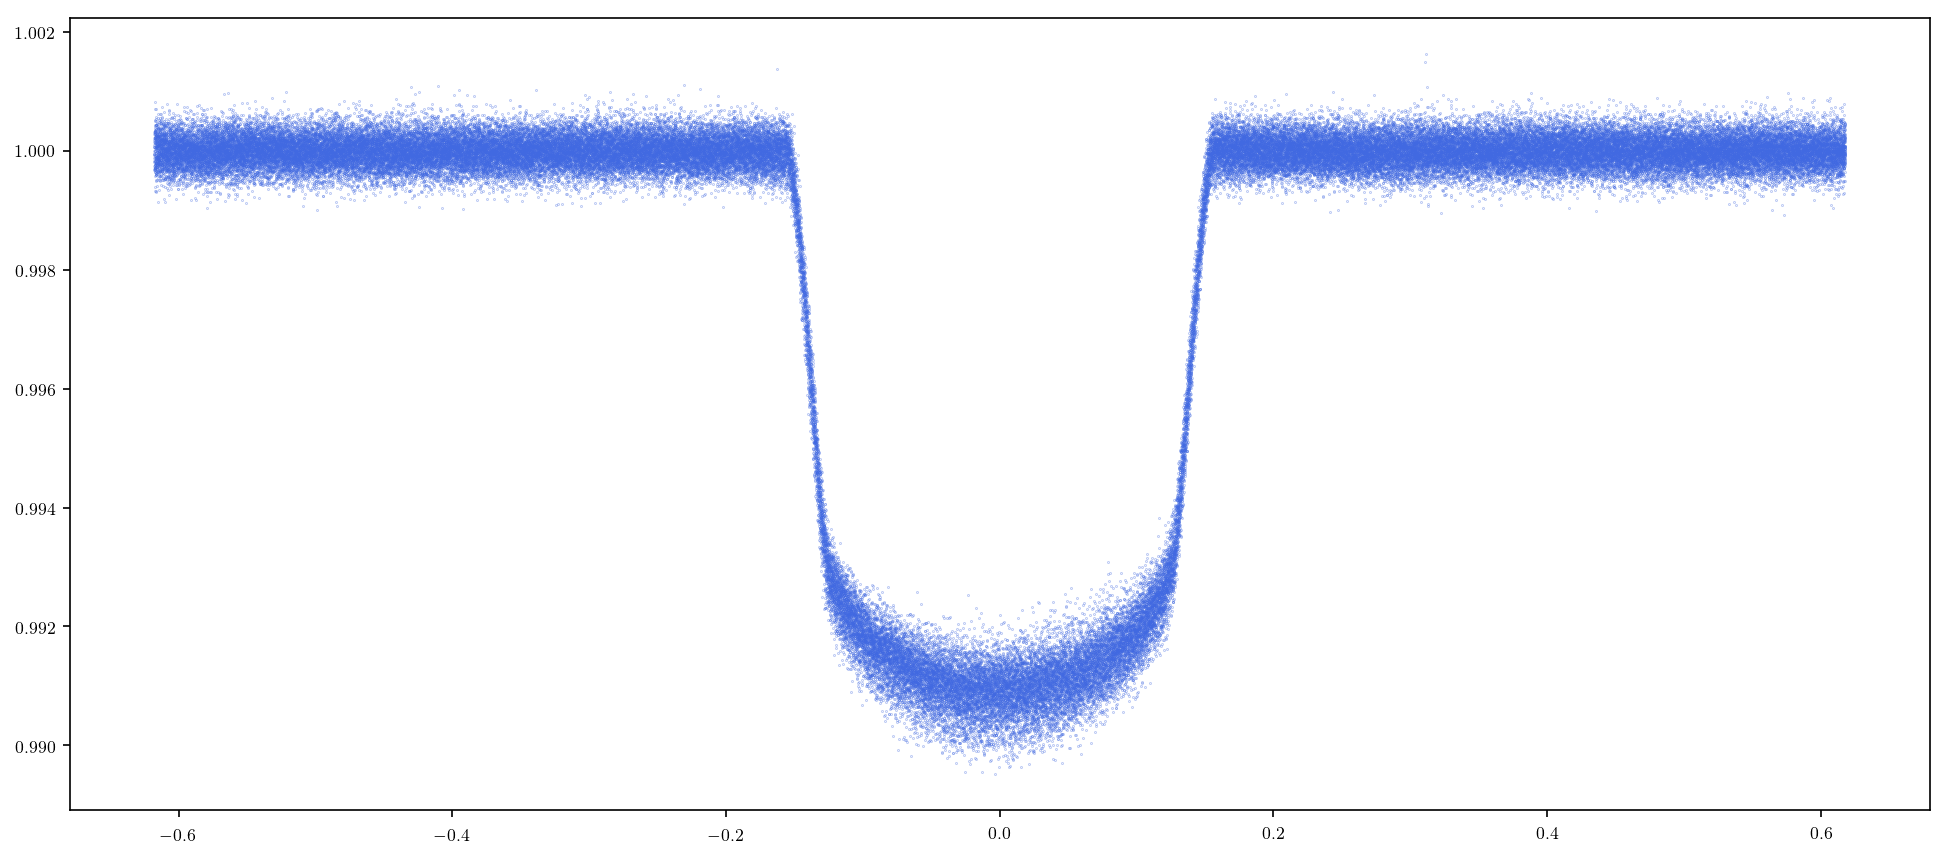

In [31]:
for target in targets:
    if target.kepid == 5812701:
        bad_tr = [23,49,65]
        target.ind_missed_transits.extend(bad_tr)
        missed_trans = set(target.ind_missed_transits)
        print(target.ind_missed_transits)
        for i in range(len(target.transit_times)): 
            if i not in missed_trans:
                plt.plot(target.ttrans[target.trans_id==i]-target.transit_times[i], target.ftrans[target.trans_id==i],'.', 
                       color = 'royalblue', ms = 0.3)

# Update Rs

Update stellar radius.

In [ ]:
path_newRs = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs'
os.chdir(path_newRs)

modified_rs = 0
for target in targets:
    for file in glob.glob(str(target.kepid)+"*[!\BAD].txt"):
        print("------------------------KID{0:d}------------------------".format(target.kepid))
        
        data = pd.read_csv(file, delimiter=" ", names = ['Rs', '+err', '-err', 'afrac'],
                           header = 1, na_values = '#N/A')
        
        data_mean = data.mean()
        rs_new = data_mean['Rs']
        rs_err_new = np.sqrt(data_mean['+err']**2+data_mean['-err']**2)
        
        print("\tOld R*: {0:0.3f} ({1:0.3f}) [Rsun]\
        \n\tNew R*: {2:0.3f} ({3:0.3f}) [Rsun]\n".format(target.rs, target.rs_err, 
                                                       rs_new, rs_err_new))
        modified_rs += 1 

        
        target.rs = rs_new
        target.rs_err = rs_err_new  
                
print("The stellar radius has been modified for {0:d} systems.".format(modified_rs))

# Global Fit

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)
    prob = np.log(rstar)-alog
    return(prob)

In [ ]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2 #b=0 centre of stellar disk & b=1 at the cusp of the disc
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    
    Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. 
    By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [ ]:
def lnprior(theta, maxb):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass)
    return -np.inf  

def lnprior_MCMC(theta, maxb): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

In [ ]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    lp = lnprior(theta, maxb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxb)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [ ]:
def run_transit_routine(star, t, f, ferr, transit_num, showLC):
    depth_guess = 1-min(f)
    rp_guess = np.sqrt(depth_guess)*star.rs
    max_b = 1+rp_guess/star.rs
    
    print("\nMax. allowed b (1+rp_guess/rs) = {0:0.5f}".format(max_b))
    print("Depth guess = {0:0.5f}. True depth = {1:0.5f}".format(depth_guess, star.depth))
    
    allfixed = np.array([star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_b])
    
    #initial_simplex = np.tile(first_guess, (len(first_guess)+1,1))
    
    nll = lambda *args: -lnprob(*args)
    
    res0 = op.minimize(nll, [depth_guess/1.15, 0.4, 0.0, star.smass, star.rs, 1.0, period_guess, 0.0], 
                       args=(t, f, 0.0, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead') #options={'maxiter': 1e3, 'disp': True}
    
    res1 = op.minimize(nll, res0["x"], 
                       args=(t, f, ferr, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead')
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res1["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title("KID"+str(star.kepid)+". Preliminary Fit for Transit "+str(transit_num+1), fontsize = 15)
        plt.plot(t, f, '.', label = 'Kepler data')
        plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    print("\tSigma (white noise):\t Fit={0:0.3f}".format(sigma_ml))
    print("\tOut-of-transit flux:\t Fit={0:0.3f}".format(f0_ml))
    
    return(res1["x"])

## MCMC 

In [ ]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, show_mcmc_res):
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    
    
    #adjust depth a little
    fit_results[0] = fit_results[0]/1.2
    
    rp_guess = np.sqrt(depth_ml)*radius_ml
    max_depth = 1+rp_guess/radius_ml
        
    print("\n------------------ Prepare MCMC ------------------")
    print("Guess impact parameter: {0:0.5f}".format(fit_results[1]))
    print("Guess of Rp [in Rsun]: {0:0.5f}".format(rp_guess))
    print("Max. allowed b (1+rp_guess/rs): {0:0.5f}".format(max_depth))

    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, 
                     star.rs_err, tKep, star.u1, star.u2, max_depth]
    
    ndim = len(fit_results)
    
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC))
    
    print("\nRunning burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 200, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
    samples = sampler.chain[:, burnin_global:, :].reshape((-1, ndim)) 
    
    """
    ************ BE CAREFUL WITH THE INDEXES OF THE FOLLOWING FOUR LINES!!!!! ************
    This is bc the indexes depend on the list of parameters being fitted.
    """
    period_distribution = samples[:,6]
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in EARTH RAD rad( rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,4]**3/samples[:, 3])/1408.0))**0.3333

    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------------------ Post-MCMC Results ------------------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp)) #In earth radii due to the conversion done above 
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0],
                        t0=tc_mcmc[0], b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1.5, 1.5, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)]); 
    
    file_path_fit = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_fits/'
    store_mcmc_fit = "fit"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+"_"+str(period_guess)+"d.png"
    fig_lc.savefig(file_path_fit+store_mcmc_fit)
    plt.close(fig_lc)
        
    #Create a corner plot
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True) 
    
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
    
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+"_"+str(period_guess)+"d.png"
    fig_corner.savefig(file_path+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: as a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter (see emcee.EnsembleSampler input options) 
    af = sampler.acceptance_fraction  
    print("\nMean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(100*np.mean(sampler.acceptance_fraction)))
    
    #Create a steps plot
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") 
    axes[0].set_ylabel(r'Depth'); 
    axes[0].axhline(true_params[0], color='red')
    
    axes[1].plot(sampler.chain[:, :, 1].T, ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); 
    axes[1].axhline(true_params[1], color='red')
    
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); 
    axes[3].axhline(true_params[3], color='red')
    
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); 
    axes[4].axhline(true_params[4], color='red')
    
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); 
    axes[5].axhline(true_params[5], color='red')
    
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); 
    axes[6].axhline(true_params[6], color='red')
    
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    return (period_distribution, results_mcmc)

## Transit Analysis

In [ ]:
steps, nwalkers, burnin_global

In [ ]:
amplify

In [ ]:
period_guess

Fit each transit with the new stellar density

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)

    fit_results = []
    period_distributions = []
    MCMC_transits = []

    for i in range(len(target.transit_times)): 
        if i in missed_trans:
            fit_results.append(0)  
            period_distributions.append(0)
            MCMC_transits.append(0)
        else: 
            print("\n*TRANSIT "+str(i+1))

            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]
            
            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)
            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
            snr = d/error_trans_oot

            print("\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))

            if  snr > snr_limit:  
                lc_fit = run_transit_routine(target, dt_i, f_trans_i, 0.1*error_trans_oot, i, True)
                fit_results.append(lc_fit)

                period_res, mcmc_res = run_mcmc(target, dt_i, f_trans_i, 0.1*error_trans_oot, i, lc_fit, True)
                period_distributions.append(period_res)

                MCMC_transits.append(mcmc_res)

                locs_P_trans = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
                locs_MCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'

                fname_P_trans = str(target.kepid)+"_st"+str(steps)+"_Pdist_trans"+str(i+1)+"_"+str(period_guess)+"d.txt"
                fname_MCMC = str(target.kepid)+"_st"+str(steps)+"_MCMCres_trans"+str(i+1)+"_"+str(period_guess)+"d.txt"

                np.savetxt(locs_P_trans+fname_P_trans, np.transpose(period_res), fmt = "%0.15f")
                np.savetxt(locs_MCMC+fname_MCMC, np.column_stack((id_mcmc, mcmc_res)), 
                                   header = header_mcmc, delimiter=" ", fmt="%s")

    target.res_transfit = fit_results
    target.P_distribution = period_distributions
    target.MCMC_transits = MCMC_transits

# Period Analysis

In [ ]:
#colors: https://matplotlib.org/examples/color/named_colors.html

def plot_periods(star):
    bin_num = 15
    fig = plt.figure(figsize=(16,14))
    ax=fig.add_subplot(211)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i]['Period'], density = True, bins=30, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Transit Period distribution', fontsize = 20)
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    if (len(star.transit_times) < 10): ax.legend(loc='best', fontsize = 12)

    ax2 = fig.add_subplot(212)
    ax2.set_title('KID'+str(star.kepid)+' - Full Period Distribution', fontsize = 20)
    ax2.hist(star.full_P['Period'], bins=bin_num*3, density = True, color='wheat', alpha = 0.5) 
    ax2.set_xlabel(r'$P$ [d]')
    ax2.set_ylabel('Frequency')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax2.legend(loc = 'best', fontsize = 12)
    plt.show()
    plt.tight_layout()
    
    path_hist = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_charts/'
    fig.savefig(path_hist+"hist"+str(star.kepid)+".png")
    plt.close(fig)

In [ ]:
def get_statistics(data):
    full_statistics = pd.DataFrame({'mean': data.mean(), 'median': data.median(),'mode': data.mode(),
                        'std': data.std(), 'min': data.min(), 'max': data.max(), 
                   '16%': data.quantile(0.16), '50%': data.quantile(0.5), '84%': data.quantile(0.84)})
    return full_statistics

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def closest_statistic(df, P):
    cols = ['Mean', 'Median', 'Mode']
    stats = [df['mean'], df['median'], df['mode']]
    res = find_nearest(stats, P)
    idx_res = np.where(stats == res)[0][0]
    return cols[idx_res]

def show_best_stats(star):
    df = pd.DataFrame({'Statistics': star.best_stats})
    freq = df['Statistics'].value_counts().to_dict()
    colors = ['lightcoral', 'lightskyblue', 'lightgreen']
    #['lightpink', 'lightgreen','lightskyblue']
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    #ax.pie(freq.values(), labels = freq.keys(), colors = colors, autopct='%1.2f%%', shadow = False, startangle = 90)
    ax.pie(freq.values(), colors = colors, autopct='%1.2f%%', shadow = False, startangle = 90)
    plt.legend(loc ='best', labels = ['%s: %d%%' % (l, s) for l, s in zip(freq.keys(), freq.values())],shadow=True)
    ax.axis('equal')  
    ax.set_title("KID"+str(star.kepid), fontsize = 15)
    left, bottom, width, height = [0.15, 0.5, 0.2, 0.2] # These are in unitless percentages of the figure size. (0,0 is bottom left)
    axins = fig.add_axes([left, bottom, width, height])
    missed_trans = set(star.ind_missed_transits)
    
    for i in range(len(target.transit_times)): 
        if i not in missed_trans:
            axins.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i],'.', 
                       color = 'royalblue', ms = 0.3)
    axins.set_xlabel('Time [d]',fontsize = 8)
    axins.set_ylabel('Flux', fontsize = 8)
    axins.set_title('LC', fontsize = 10)
    plt.tight_layout()
    plt.show()
    
    path_pie = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_charts/'
    fig.savefig(path_pie+"pie"+str(star.kepid)+".png")
    plt.close(fig)

In [ ]:
path_newRs = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
os.chdir(path_newRs)

count = 0
save_best_stats = []

for target in targets:
    period_distribution = []
    P_trans_stats = []
    best_statistics = []
    search_files = glob.glob(path_newRs+str(target.kepid)+"*[!_BAD].txt")
    
    if len(search_files) != 0:
        for i in range(len(search_files)):
            filename = search_files[i]
            Ptrans = pd.read_csv(filename, sep = " ", names=['Period'], index_col = None)
            period_distribution.append(Ptrans)
            trans_stats = get_statistics(Ptrans['Period']).iloc[0]
            P_trans_stats.append(trans_stats)
            best_statistics.append(closest_statistic(trans_stats, target.P))
        target.full_P_trans = period_distribution
        target.full_P = pd.concat(period_distribution)
        target.best_stats = best_statistics
        save_best_stats.append(best_statistics)
        
        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P['Period'])
        plot_periods(target)
        show_best_stats(target)
        count += 1

In [ ]:
print(count)
save_best_stats = list(itertools.chain.from_iterable(save_best_stats))
print(save_best_stats)

In [ ]:
import seaborn as sns
path_resMCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'
path_pie = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_charts/'

for target in targets:
    getmc = glob.glob(path_resMCMC+str(target.kepid)+"*[!_BAD].txt")
    num_trans = 0
    
    if len(getmc) != 0:
        print("\n--------------------------------KID"+str(target.kepid)+"--------------------------------")
        print("True Period:", target.P)
        
        xtrans = []
        oc = []
        
        for i in range(len(getmc)): 
            filename = getmc[i]
            num_trans += 1
            data = {}
            for line in open(filename):
                if line.startswith("#"):
                    continue
                field_name, values = line.split(":")
                data[field_name] = values.split(" ")
            
            df = pd.DataFrame(data)
            
            est_p = float(df['Orbital Period (P, [days])'][1]) #this is the median result for each transit
            xtrans.append(i)
            oc.append(est_p-target.P)
        
        #print(oc)
        print("Standard deviation OC [d]:", np.std(oc))
        print("Mean OC [d]:", np.mean(oc))
        print("Mean Estimated Period [d]:", np.mean(est_p))
        
        textstr = 'Mean O-C = {0:.2f} d\nstd O-C = {1:.2f} d\nEstimated Period = {2:.2f} d'.format(np.mean(oc),
                                                                                                np.std(oc), 
                                                                                                np.mean(est_p))

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)
        ax.axhline(y = 0, c = 'r', ls= 'dotted', lw=3, label = 'True Period ({0:.2f} d)'.format(target.P))
        ax.scatter(xtrans, oc, s = 12)
        ax.set_xlabel('Transit number')
        ax.set_ylabel('O-C')
        ax.set_title('Residuals Distribution')
        ax.annotate(textstr, xy=(0.25, 0.8), xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='bottom', backgroundcolor='wheat',alpha=.85)
        plt.legend()
        plt.savefig(path_pie+'OC'+str(target.kepid)+".png")
        plt.show()
 

PLanet radius vs. orbital period (fig 7 scatter plot http://iopscience.iop.org/article/10.3847/0004-637X/822/2/86/pdf)

keylist = set(list(ugly_stars.keys()))
bad_transits = list(ugly_stars.values())
print(keylist)
#print(bad_transits)
print(ugly_stars)